# Wikidata Profiler #
- wikidata datadump profiler and extractor



## ✅ Download Wikidata Data Dumps

- Documentation: https://www.wikidata.org/wiki/Wikidata:Database_download
- Data dumps: https://dumps.wikimedia.org/wikidatawiki/entities/

Download the data dumps from the above link.

## ✅ Entire Wikidata Data Dumps

In [ ]:
## SET download file
mode = 'prod'  # SET: test, prod
if mode == 'test':
    file_name = "../wikidata-10K.json"
    fileopen = open(file_name)
    total = 10000
if mode == 'prod':
    file_name = "wikidata-20210630-all.json.gz"
    fileopen = gzip.open(file_name, 'rt')
    total = 93526664

In [ ]:
import pandas as pd
import json
import gzip
from tqdm import tqdm

def count_update(global_dict, key_tocheck, update_val):
    """ Update count in dict if key value present, using globals """
    if key_tocheck not in global_dict:
        global_dict[key_tocheck] = update_val
    elif key_tocheck in global_dict:
        global_dict[key_tocheck] += update_val

def count_update_str(global_dict, key_tocheck, update_val):
    """ Update string value in dict if key value present, using globals """
    if key_tocheck not in global_dict:
        global_dict[key_tocheck] = update_val
    if key_tocheck in global_dict and global_dict[key_tocheck] != update_val:
        global_dict[key_tocheck] += ", " + update_val

def count_update_nested(global_dict, key_tocheck1, key_tocheck2, update_val):
    """ Update count in dict if key value present, using globals """
    if key_tocheck1 not in global_dict:
        global_dict[key_tocheck1] = {key_tocheck2: update_val}
    elif key_tocheck1 in global_dict and key_tocheck2 not in global_dict[key_tocheck1]:
        global_dict[key_tocheck1][key_tocheck2] = update_val
    elif key_tocheck1 in global_dict and key_tocheck2 in global_dict[key_tocheck1]:
        global_dict[key_tocheck1][key_tocheck2] += update_val


""" # # # # # Entities (or Items) Level """
# # # # # Count of unique items
uniq_items_count = 0

# # # # # Count of labels, descriptions, alias in each language
label_langs_counts = {}
desc_langs_counts = {}
alias_langs_counts = {}
alias_langs_uniq_ent_counts = {}  # entities with at least 1 alias

# # # # # P31_obj Sets
P31_obj_sets_counts = {}

P31_obj_sets_label_langs_counts = {}
P31_obj_sets_desc_langs_counts = {}
P31_obj_sets_alias_langs_counts = {}
P31_obj_sets_alias_langs_uniq_ent_counts = {}

P31_obj_sets_prop_hasqualifier_counts = {}
P31_obj_sets_prop_hasreference_counts = {}

P31_obj_sets_wikisite_counts = {}
P31_obj_sets_wikisite_badges_counts = {}

P31_obj_sets_byqid = {} # Qid: P31_obj_set - keep in memory from first run
P31_obj_sets_asobj = {} # P31_obj_set: (count)

# # # # # Wikipedia Sitelinks
wikisite_counts = {}
wikisite_badges_counts = {}

""" # # # # # Ontology (or Properties) Level """
# # # # # Count of unique properties and instances
uniq_props_count = 0
prop_dupelist = {}
prop_label_en = {}
prop_isvalue_counts = {}
prop_somevalue_counts = {}
prop_novalue_counts = {}
prop_uniq_ent_counts = {}
prop_datatypes = {}
prop_hasqualifier_isvalue_counts = {}       # hasqualifier means prop Pxx has ## total qualifiers
prop_isqualifier_isvalue_counts = {}
prop_isqualifier_somevalue_counts = {}
prop_isqualifier_novalue_counts = {}
prop_hasreference_counts = {}
prop_asreference_counts = {}

# # # # # Count of labels, descriptions, alias in each language
prop_label_langs_counts = {}
prop_desc_langs_counts = {}
prop_alias_langs_counts = {}
prop_alias_langs_uniq_ent_counts = {}

# mode = 'prod'  # SET: test, prod
# if mode == 'test':
#     file_name = "../wikidata-10K.json"
#     fileopen = open(file_name)
#     total = 10000
# if mode == 'prod':
#     file_name = "wikidata-20210630-all.json.gz"
#     fileopen = gzip.open(file_name, 'rt')
#     total = 93526664

with fileopen as txt_file:
    for line in tqdm(txt_file, total=total):
        try:
            if line.startswith("{"):
                ln_json = json.loads(line[:-2])
                # Items
                if ln_json['type'] == "item":
                    wd_id = ln_json['id']
                    # item count
                    uniq_items_count += 1
                    # labels
                    labels = ln_json['labels'].keys()
                    for lang1 in labels:
                        count_update(label_langs_counts, lang1, 1)
                    # desc
                    descs = ln_json['descriptions'].keys()
                    for lang2 in descs:
                        count_update(desc_langs_counts, lang2, 1)
                    # aliases
                    aliases = ln_json['aliases'].keys()
                    for lang3 in aliases:
                        alias_count = len(ln_json['aliases'][lang3])
                        count_update(alias_langs_counts, lang3, alias_count)
                        # for each unique entity
                        count_update(alias_langs_uniq_ent_counts, lang3, 1)
                    # claims
                    claims_props = ln_json['claims'].keys()
                    for claim_prop in claims_props:
                        prop = claim_prop
                        prop_datavalues = ln_json['claims'][claim_prop]
                        # P31_obj stats
                        if prop == "P31":
                            P31_obj_list = []
                            # iterate through list of dicts
                            for dv_dict in prop_datavalues:
                                dv = dv_dict['mainsnak']
                                obj_val = dv['datavalue']['value']['id']
                                P31_obj_list.append(obj_val)
                            P31_obj_list.sort()  # sort the list so keys are consistent
                            P31_obj_set = ", ".join(P31_obj_list)
                            count_update(P31_obj_sets_counts, P31_obj_set, 1)
                            
                            # First pass run
                            count_update_str(P31_obj_sets_byqid, wd_id, P31_obj_set)
                            
                        # iterate through list of dicts
                        for dv_dict in prop_datavalues:
                            dv = dv_dict['mainsnak']
                            is_value  = dv.get('snaktype')  # value, somevalue, novalue
                            obj_dtype = dv['datatype']
                            count_update_str(prop_datatypes, prop, obj_dtype)
                            lang_val = None  # default as None
                            if is_value == "value":
                                count_update(prop_isvalue_counts, prop, 1)
                            elif is_value == "somevalue":
                                count_update(prop_somevalue_counts, prop, 1)
                            elif is_value == "novalue":
                                count_update(prop_novalue_counts, prop, 1)
                            # qualifiers
                            qualifiers = dv_dict.get('qualifiers')  # None if no key exists
                            if qualifiers:
                                # qualifiers - for this prop, how many qualifiers does it have
                                count_update(prop_hasqualifier_isvalue_counts, prop, len(qualifiers))
                                # qualifiers - for this prop, what prop is used AS qualifier
                                prop_quals = qualifiers.keys()
                                for prop_qual in prop_quals:
                                    for pq in qualifiers[prop_qual]:
                                        is_value_qual = pq['snaktype']
                                        if is_value_qual == "value":
                                            count_update(prop_isqualifier_isvalue_counts, prop_qual, 1)
                                        elif is_value == "somevalue":
                                            count_update(prop_isqualifier_somevalue_counts, prop_qual, 1)
                                        elif is_value == "novalue":
                                            count_update(prop_isqualifier_novalue_counts, prop_qual, 1)
                                        # LATER to get value: qualifiers[prop_qual][0]['datavalue']['value']
                                # for P31_obj_set x prop matrix
                                if P31_obj_set:
                                    count_update_nested(P31_obj_sets_prop_hasqualifier_counts, prop, P31_obj_set, len(qualifiers))
                                    
                            
                            # references
                            references = dv_dict.get('references')  # None if no key exists
                            if references:
                                # references - for this prop, how many references does it have
                                count_update(prop_hasreference_counts, prop, len(references))
                                # references - for this prop, what prop is used AS reference
                                for prop_ref_indx in references:  # is list
                                    prop_refs = prop_ref_indx['snaks'].keys()  # iterate here
                                    for prop_ref in prop_refs:
                                        count_update(prop_asreference_counts, prop_ref, 1)
                                    # LATER to get value: references[0]['snaks'][prop_ref][0]['datavalue']['value']
                                # for P31_obj_set x prop matrix
                                if P31_obj_set:
                                    count_update_nested(P31_obj_sets_prop_hasreference_counts, prop, P31_obj_set, len(references))
                                        
                        # prop count only once for each unique entity
                        count_update(prop_uniq_ent_counts, prop, 1)
                        
                    # wikisite sitelinks
                    wikisite = ln_json['sitelinks'].keys()
                    for wiki in wikisite:
                        count_update(wikisite_counts, wiki, 1)
                        badge = ln_json['sitelinks'][wiki].get('badges')
                        if badge: 
                            count_update(wikisite_badges_counts, wiki, len(badge))
                    
                    # For P31 obj: label, desc, alias counts
                    if P31_obj_set:
                        # labels
                        labels = ln_json['labels'].keys()
                        for lang1_P31 in labels:
                            count_update_nested(P31_obj_sets_label_langs_counts, lang1_P31, P31_obj_set, 1)
                        # desc
                        descs = ln_json['descriptions'].keys()
                        for lang2_P31 in descs:
                            count_update_nested(P31_obj_sets_desc_langs_counts, lang2_P31, P31_obj_set, 1)
                        # aliases
                        aliases = ln_json['aliases'].keys()
                        for lang3_P31 in aliases:
                            alias_count = len(ln_json['aliases'][lang3_P31])
                            count_update_nested(P31_obj_sets_alias_langs_counts, lang3_P31, P31_obj_set, alias_count)
                            # for each unique entity
                            count_update_nested(P31_obj_sets_alias_langs_uniq_ent_counts, lang3_P31, P31_obj_set, 1)
                        # wikisite sitelinks
                        wikisite = ln_json['sitelinks'].keys()
                        for wiki in wikisite:
                            count_update_nested(P31_obj_sets_wikisite_counts, wiki, P31_obj_set, 1)
                            badge = ln_json['sitelinks'][wiki].get('badges')
                            if badge: 
                                count_update_nested(P31_obj_sets_wikisite_badges_counts, wiki, P31_obj_set, len(badge))
                    # !!! #
                    P31_obj_set = None  # set back to None or else catches entities without P31 prop triples

                # Properties
                elif ln_json['type'] == "property":
                    # Property id
                    wd_id_prop = ln_json['id']
                    # prop count
                    uniq_props_count += 1
                    # add to dupelist to ensure props not missed
                    count_update_str(prop_dupelist, wd_id_prop, wd_id_prop)
                    # labels
                    labels = ln_json['labels'].keys()
                    for lang1 in labels:
                        count_update(prop_label_langs_counts, lang1, 1)
                        # To add en label to downstream `prop_dict_final`
                        if lang1 == "en":
                            label_en_prop = ln_json['labels']['en']['value']
                            count_update_str(prop_label_en, wd_id_prop, label_en_prop)
                    # desc
                    descs = ln_json['descriptions'].keys()
                    for lang2 in descs:
                        count_update(prop_desc_langs_counts, lang2, 1)
                    # aliases
                    aliases = ln_json['aliases'].keys()
                    for lang3 in aliases:
                        alias_count = len(ln_json['aliases'][lang3])
                        count_update(prop_alias_langs_counts, lang3, alias_count)
                        # for each unique entity
                        count_update(prop_alias_langs_uniq_ent_counts, lang3, 1)
        except:
            pass


""" Output TSVs """
# FOR all entities: label, desc, alias, alias uniq_ent
dict_final = {'label_langs_counts': label_langs_counts,
              'desc_langs_counts': desc_langs_counts,
              'alias_langs_counts': alias_langs_counts,
              'alias_langs_uniq_ent_counts': alias_langs_uniq_ent_counts}
pd_entities_counts = pd.DataFrame.from_dict(dict_final)
# pd_entities_counts.to_csv('wd-counts-entities-label-desc-alias.tsv', sep='\t', index_label='lang')

# FOR all entities with P31_objs: P31_obj sets
P31_obj_dict_final = {'P31_obj_sets_counts': P31_obj_sets_counts }
pd_P31_obj_sets_counts = pd.DataFrame.from_dict(P31_obj_dict_final)
pd_P31_obj_sets_counts.to_csv('wd-counts-P31-obj-sets.tsv', sep='\t', index_label='P31_obj_set')

pd_P31_obj_sets_label_langs_counts = pd.DataFrame.from_dict(P31_obj_sets_label_langs_counts)
pd_P31_obj_sets_label_langs_counts.to_csv('wd-counts-P31-obj-sets-xlabel.tsv', sep='\t', index_label='P31_obj_set')

pd_P31_obj_sets_desc_langs_counts = pd.DataFrame.from_dict(P31_obj_sets_desc_langs_counts)
pd_P31_obj_sets_desc_langs_counts.to_csv('wd-counts-P31-obj-sets-xdesc.tsv', sep='\t', index_label='P31_obj_set')

pd_P31_obj_sets_alias_langs_counts = pd.DataFrame.from_dict(P31_obj_sets_alias_langs_counts)
pd_P31_obj_sets_alias_langs_counts.to_csv('wd-counts-P31-obj-sets-xalias.tsv', sep='\t', index_label='P31_obj_set')

pd_P31_obj_sets_alias_langs_uniq_ent_counts = pd.DataFrame.from_dict(P31_obj_sets_alias_langs_uniq_ent_counts)
pd_P31_obj_sets_alias_langs_uniq_ent_counts.to_csv('wd-counts-P31-obj-sets-xalias-uniq.tsv', sep='\t', index_label='P31_obj_set')

pd_P31_obj_sets_prop_hasqualifier_counts = pd.DataFrame.from_dict(P31_obj_sets_prop_hasqualifier_counts)
pd_P31_obj_sets_prop_hasqualifier_counts.to_csv('wd-counts-P31-obj-sets-xprop-hasqualifier.tsv', sep='\t', index_label='P31_obj_set')

pd_P31_obj_sets_prop_hasreference_counts = pd.DataFrame.from_dict(P31_obj_sets_prop_hasreference_counts)
pd_P31_obj_sets_prop_hasreference_counts.to_csv('wd-counts-P31-obj-sets-xprop-hasreference.tsv', sep='\t', index_label='P31_obj_set')

pd_P31_obj_sets_wikisite_counts = pd.DataFrame.from_dict(P31_obj_sets_wikisite_counts)
pd_P31_obj_sets_wikisite_counts.loc[:,'Row Total'] = pd_P31_obj_sets_wikisite_counts.sum(axis=1)  # add row sums
COLS = pd_P31_obj_sets_wikisite_counts.columns.tolist() # Reorder rows for readability
COLS.remove('Row Total')
pd_P31_obj_sets_wikisite_counts_COLS = ['Row Total'] + COLS
pd_P31_obj_sets_wikisite_counts = pd_P31_obj_sets_wikisite_counts[ pd_P31_obj_sets_wikisite_counts_COLS ]
pd_P31_obj_sets_wikisite_counts.to_csv('wd-counts-P31-obj-sets-xwikisite.tsv', sep='\t', index_label='P31_obj_set')

pd_P31_obj_sets_wikisite_badges_counts = pd.DataFrame.from_dict(P31_obj_sets_wikisite_badges_counts)
pd_P31_obj_sets_wikisite_badges_counts.loc[:,'Row Total'] = pd_P31_obj_sets_wikisite_badges_counts.sum(axis=1)  # add row sums
COLS = pd_P31_obj_sets_wikisite_badges_counts.columns.tolist() # Reorder rows for readability
COLS.remove('Row Total')
pd_P31_obj_sets_wikisite_badges_counts_COLS = ['Row Total'] + COLS
pd_P31_obj_sets_wikisite_badges_counts = pd_P31_obj_sets_wikisite_badges_counts[ pd_P31_obj_sets_wikisite_badges_counts_COLS ]
pd_P31_obj_sets_wikisite_badges_counts.to_csv('wd-counts-P31-obj-sets-xwikisite-badges.tsv', sep='\t', index_label='P31_obj_set')

dict_final2 = {'wikisite_counts': wikisite_counts,
               'wikisite_badges_counts': wikisite_badges_counts} 
pd_wikisite_counts = pd.DataFrame.from_dict(dict_final2)
pd_wikisite_counts.to_csv('wd-counts-entities-wikisite.tsv', sep='\t', index_label='lang_wiki')

# FOR all properties: counts, uniq_ent counts
prop_dict_final = {'prop_isvalue_counts': prop_isvalue_counts,
                   'prop_label_en': prop_label_en,
                   'prop_dupelist': prop_dupelist,
                   'prop_somevalue_counts': prop_somevalue_counts,
                   'prop_novalue_counts': prop_novalue_counts,
                   'prop_uniq_ent_counts': prop_uniq_ent_counts,
                   'prop_datatypes': prop_datatypes,
                   'prop_hasqualifier_isvalue_counts': prop_hasqualifier_isvalue_counts,
                   'prop_isqualifier_isvalue_counts': prop_isqualifier_isvalue_counts,
                   'prop_isqualifier_somevalue_counts': prop_isqualifier_somevalue_counts,
                   'prop_isqualifier_novalue_counts': prop_isqualifier_novalue_counts,
                   'prop_hasreference_counts': prop_hasreference_counts,
                   'prop_asreference_counts': prop_asreference_counts}
pd_prop_xvalue_counts = pd.DataFrame.from_dict(prop_dict_final)
pd_prop_xvalue_counts.to_csv('wd-counts-entities-claims-props.tsv', sep='\t', index_label='prop')

# FOR all properties: label, desc, alias, alias uniq_ent
dict_final3 = {'prop_label_langs_counts': prop_label_langs_counts,
               'prop_desc_langs_counts': prop_desc_langs_counts,
               'prop_alias_langs_counts': prop_alias_langs_counts,
               'prop_alias_langs_uniq_ent_counts': prop_alias_langs_uniq_ent_counts}
pd_prop_langs_counts = pd.DataFrame.from_dict(dict_final3)
pd_prop_langs_counts.to_csv('wd-counts-props-label-desc-alias.tsv', sep='\t', index_label='lang')

# Print final results overview
final_results = """
= = = = = DONE = = = = =
# # # # # Entities (or Items)
- - Number of unique items: uniq_items_count: {uniq_items_count}

# # # # # Count of labels, descriptions, alias in each language
- Number of unique languages in labels, desc, or alias: {uniq_langs_counts}
- Done - check output TSV:
    - label_langs_counts
    - desc_langs_counts
    - alias_langs_counts
    - alias_langs_uniq_ent_counts

- Description:
{entities_counts_describe}
- Sums:
{entities_counts_sum}

# # # # # P31_obj Sets
- Done - check output TSV:
    - P31_obj_sets

- Description:
{P31_obj_sets_counts_describe}
- Sums:
{P31_obj_sets_counts_sum}


# # # # # Ontology (or Properties)
# # # # # Count of unique properties and instances
- Number of unique properties: uniq_props_count: {uniq_props_count}
- Done - check output TSV: 
    - prop_isvalue_counts 
    - prop_somevalue_counts
    - prop_novalue_counts
    - prop_uniq_ent_counts
    - prop_datatypes
    - prop_isqualifier_isvalue_counts
    - prop_isqualifier_somevalue_counts
    - prop_isqualifier_novalue_counts 

- Description:
{prop_xvalue_counts_describe}
- Sums:
{prop_xvalue_counts_sum}


# # # # # Count of labels, descriptions, alias in each language
- Done - check output TSV
    - prop_label_langs_counts
    - prop_desc_langs_counts
    - prop_alias_langs_counts
    - prop_alias_langs_uniq_ent_counts

- Description:
{prop_langs_counts_describe}
- Sums:
{prop_langs_counts_sum}

= = = = = =  = = = = = =
= = = = = DONE = = = = =
""".format(uniq_items_count   = uniq_items_count,
           uniq_langs_counts  = len(pd_entities_counts),
           entities_counts_describe = pd_entities_counts.describe(),
           entities_counts_sum      = pd_entities_counts.sum(),
           P31_obj_sets_counts_describe = pd_P31_obj_sets_counts.describe(),
           P31_obj_sets_counts_sum      = pd_P31_obj_sets_counts.sum(),
           label_langs_counts_sum = pd_entities_counts['label_langs_counts'].sum(),
           uniq_props_count = uniq_props_count,
           prop_xvalue_counts_describe = pd_prop_xvalue_counts.describe(),
           prop_xvalue_counts_sum      = pd_prop_xvalue_counts.sum(),
           prop_langs_counts_describe = pd_prop_langs_counts.describe(),
           prop_langs_counts_sum      = pd_prop_langs_counts.sum() )
print(final_results)

In [ ]:
# 2nd pass run
import pandas as pd
import json
import gzip
from tqdm import tqdm

def count_update(global_dict, key_tocheck, update_val):
    """ Update count in dict if key value present, using globals """
    if key_tocheck not in global_dict:
        global_dict[key_tocheck] = update_val
    elif key_tocheck in global_dict:
        global_dict[key_tocheck] += update_val

def count_update_str(global_dict, key_tocheck, update_val):
    """ Update string value in dict if key value present, using globals """
    if key_tocheck not in global_dict:
        global_dict[key_tocheck] = update_val
    if key_tocheck in global_dict and global_dict[key_tocheck] != update_val:
        global_dict[key_tocheck] += ", " + update_val

def count_update_nested(global_dict, key_tocheck1, key_tocheck2, update_val):
    """ Update count in dict if key value present, using globals """
    if key_tocheck1 not in global_dict:
        global_dict[key_tocheck1] = {key_tocheck2: update_val}
    elif key_tocheck1 in global_dict and key_tocheck2 not in global_dict[key_tocheck1]:
        global_dict[key_tocheck1][key_tocheck2] = update_val
    elif key_tocheck1 in global_dict and key_tocheck2 in global_dict[key_tocheck1]:
        global_dict[key_tocheck1][key_tocheck2] += update_val


""" # # # # # Entities (or Items) Level """
# # # # # P31_obj Sets

# P31_obj_sets_byqid = {} # Qid: P31_obj_set      # !!! Not to overwrite: keep in memory from first run
P31_obj_sets_asobj = {} # P31_obj_set: (count)


mode = 'prod'  # test, prod
if mode == 'test':
    file_name = "../wikidata-10K.json"
    fileopen = open(file_name)
    total = 10000
if mode == 'prod':
    file_name = "wikidata-20210630-all.json.gz"
    fileopen = gzip.open(file_name, 'rt')
    total = 93526664

with fileopen as txt_file:
    for line in tqdm(txt_file, total=total):
        try:
            if line.startswith("{"):
                ln_json = json.loads(line[:-2])
                # Items
                if ln_json['type'] == "item":
                    wd_id = ln_json['id']
                    # claims
                    claims_props = ln_json['claims'].keys()
                    for claim_prop in claims_props:
                        prop = claim_prop
                        prop_datavalues = ln_json['claims'][claim_prop]
                        # P31_obj stats - removed: ...
                            
                        # iterate through list of dicts
                        for dv_dict in prop_datavalues:
                            dv = dv_dict['mainsnak']
                            is_value  = dv.get('snaktype')  # value, somevalue, novalue
                            obj_dtype = dv['datatype']
                            if obj_dtype == "wikibase-item" and is_value == 'value':
                                obj_id = dv['datavalue']['value']['id']
                                # Lookup in dict from first pass
                                P31_asobj = P31_obj_sets_byqid[obj_id]
                                count_update(P31_obj_sets_asobj, P31_asobj, 1)

                    # !!! #
                    #P31_obj_set = None  # set back to None or else catches entities without P31 prop triples

        except:
            pass


""" Output TSVs"""
# FOR all entities with P31_objs: P31_obj sets
P31_obj_dict_final = {'P31_obj_sets_counts': P31_obj_sets_counts,  # from first pass
                      'P31_obj_sets_asobj': P31_obj_sets_asobj }
pd_P31_obj_sets_counts = pd.DataFrame.from_dict(P31_obj_dict_final)
pd_P31_obj_sets_counts.to_csv('wd-counts-P31-obj-sets.tsv', sep='\t', index_label='P31_obj_set')

# FOR Qid and its P31_obj sets
pd_P31_obj_sets_byqid = pd.DataFrame.from_dict(P31_obj_sets_byqid, orient='index', columns=['P31_obj_set'])
pd_P31_obj_sets_byqid.index.name = 'Qid'
pd_P31_obj_sets_byqid.to_csv('wd-Qid-P31-obj-sets.tsv', sep='\t', index_label='Qid')

# Print final results overview
final_results = """
= = = = = DONE = = = = =
...

# # # # # P31_obj Sets
- Done - check output TSV:
    - P31_obj_sets

- Description:
{P31_obj_sets_counts_describe}
- Sums:
{P31_obj_sets_counts_sum}

...
= = = = = =  = = = = = =
= = = = = DONE = = = = =
""".format(
           P31_obj_sets_counts_describe = pd_P31_obj_sets_counts.describe(),
           P31_obj_sets_counts_sum      = pd_P31_obj_sets_counts.sum(),
           )
print(final_results)

In [6]:
# Filling in some missed sets for completeness
a = pd_P31_obj_sets_counts.index.tolist()
b = pd_P31_obj_sets_label_langs_counts.index.tolist()
c = [s for s in a if s not in b]  # misses these from P31_obj_set TSV - b/c instances have no labels at all
c

['Q1007870, Q17362920',
 'Q104696061, Q1125338',
 'Q104696061, Q305178',
 'Q104696061, Q7234272',
 'Q104966365',
 'Q1053214',
 'Q11173, Q4634079',
 'Q11621914',
 'Q12540664, Q18127, Q2442401, Q4830453',
 'Q1323960',
 'Q132821, Q5655230, Q916412',
 'Q1443316, Q482, Q7366',
 'Q145167',
 'Q1531905',
 'Q1630622, Q2453700, Q53628522, Q71236553',
 'Q1630622, Q53628296, Q53628522',
 'Q165145, Q29549240',
 'Q170477, Q483453',
 'Q193220, Q728',
 'Q2400350',
 'Q2625603, Q37732, Q748250',
 'Q28518354',
 'Q29972039',
 'Q309, Q811979',
 'Q358, Q93338609',
 'Q3789357',
 'Q4555537',
 'Q7617617',
 'Q8544',
 'Q93740491',
 'Q943055',
 'Q95685937',
 'Q95798941',
 'Q96310233']

In [7]:
d = pd_P31_obj_sets_label_langs_counts
d['P31_obj_set'] = d.index 

for missing in c:
    d = d.append({'P31_obj_set': missing}, ignore_index=True)
d.index = d['P31_obj_set']
del d['P31_obj_set']  # as it is duplicated
d.to_csv('wd-counts-P31-obj-sets-xlabel.tsv', sep='\t', index_label='P31_obj_set')

### ➡️ Distribution of properties 

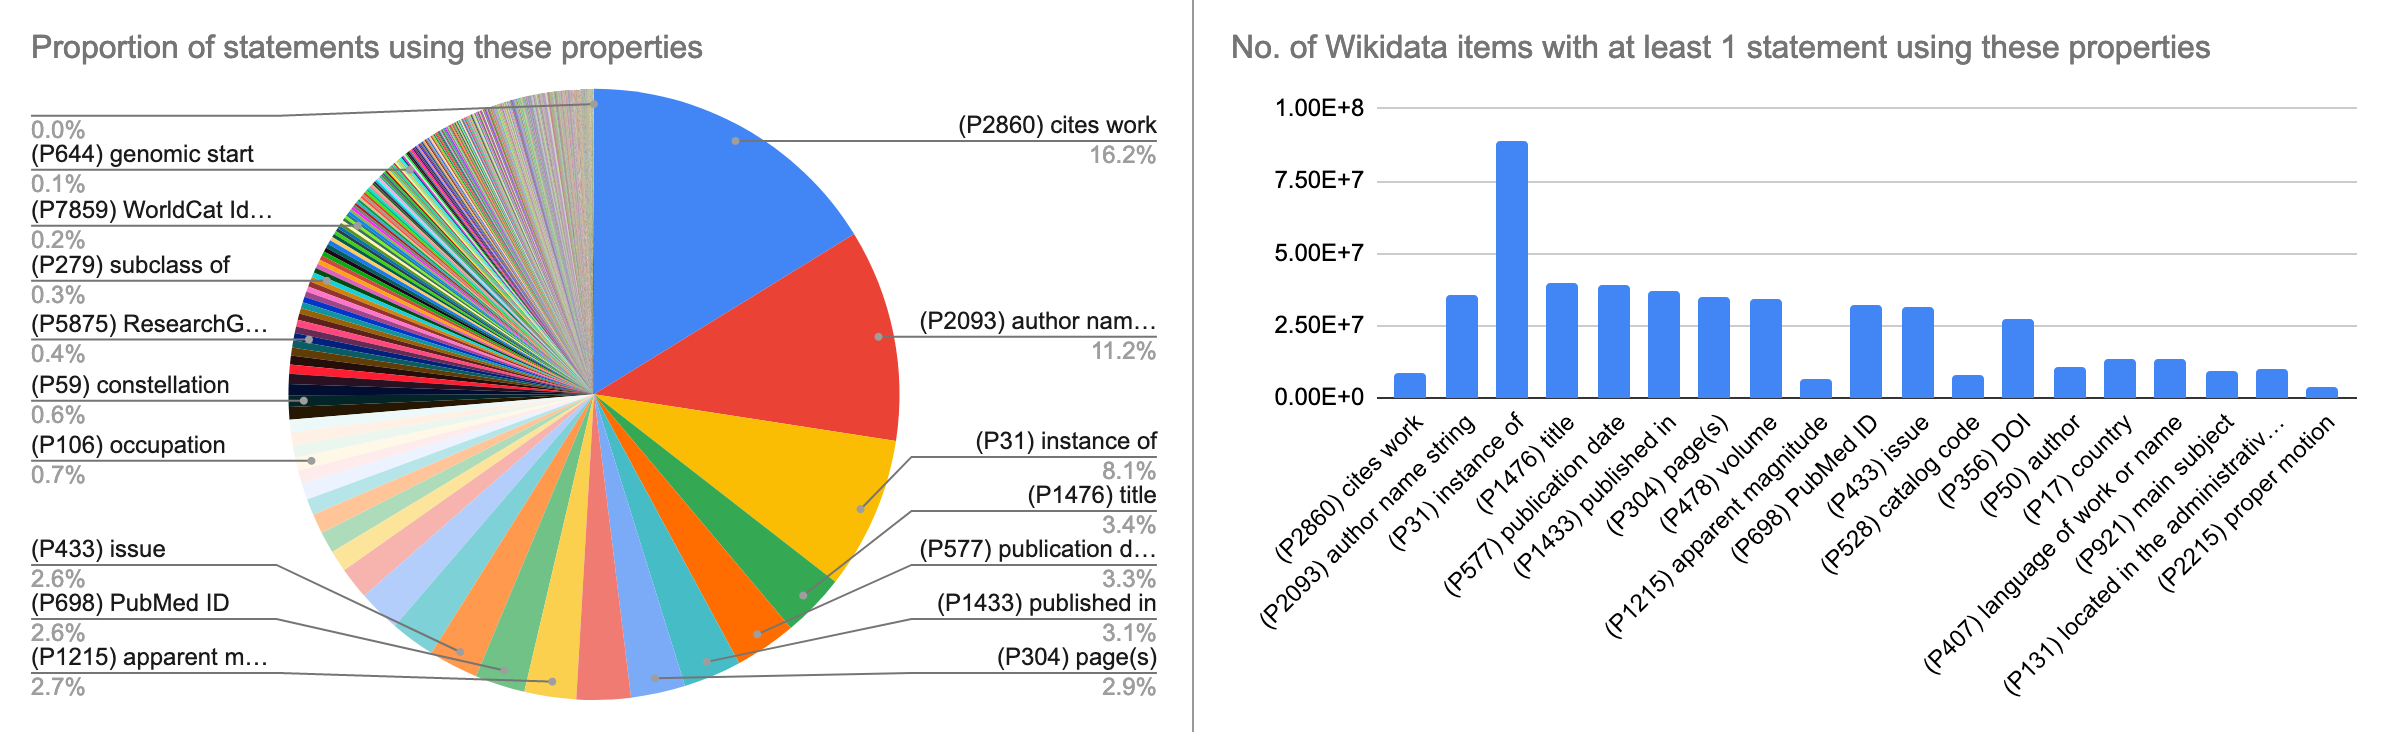

In [3]:
from IPython.display import display
from PIL import Image
# 20210301 Wikidata dump
path="../Screenshot-piechart-bar.png"
display(Image.open(path))

### ➡️ Language-wide Profiling - label, description, alias ##

In [9]:
# Language-wide descriptive statistics for label, description, alias 
# Output: `wd-langs-list-counts.tsv` duplicated `wd-counts-entities-label-desc-alias.tsv`

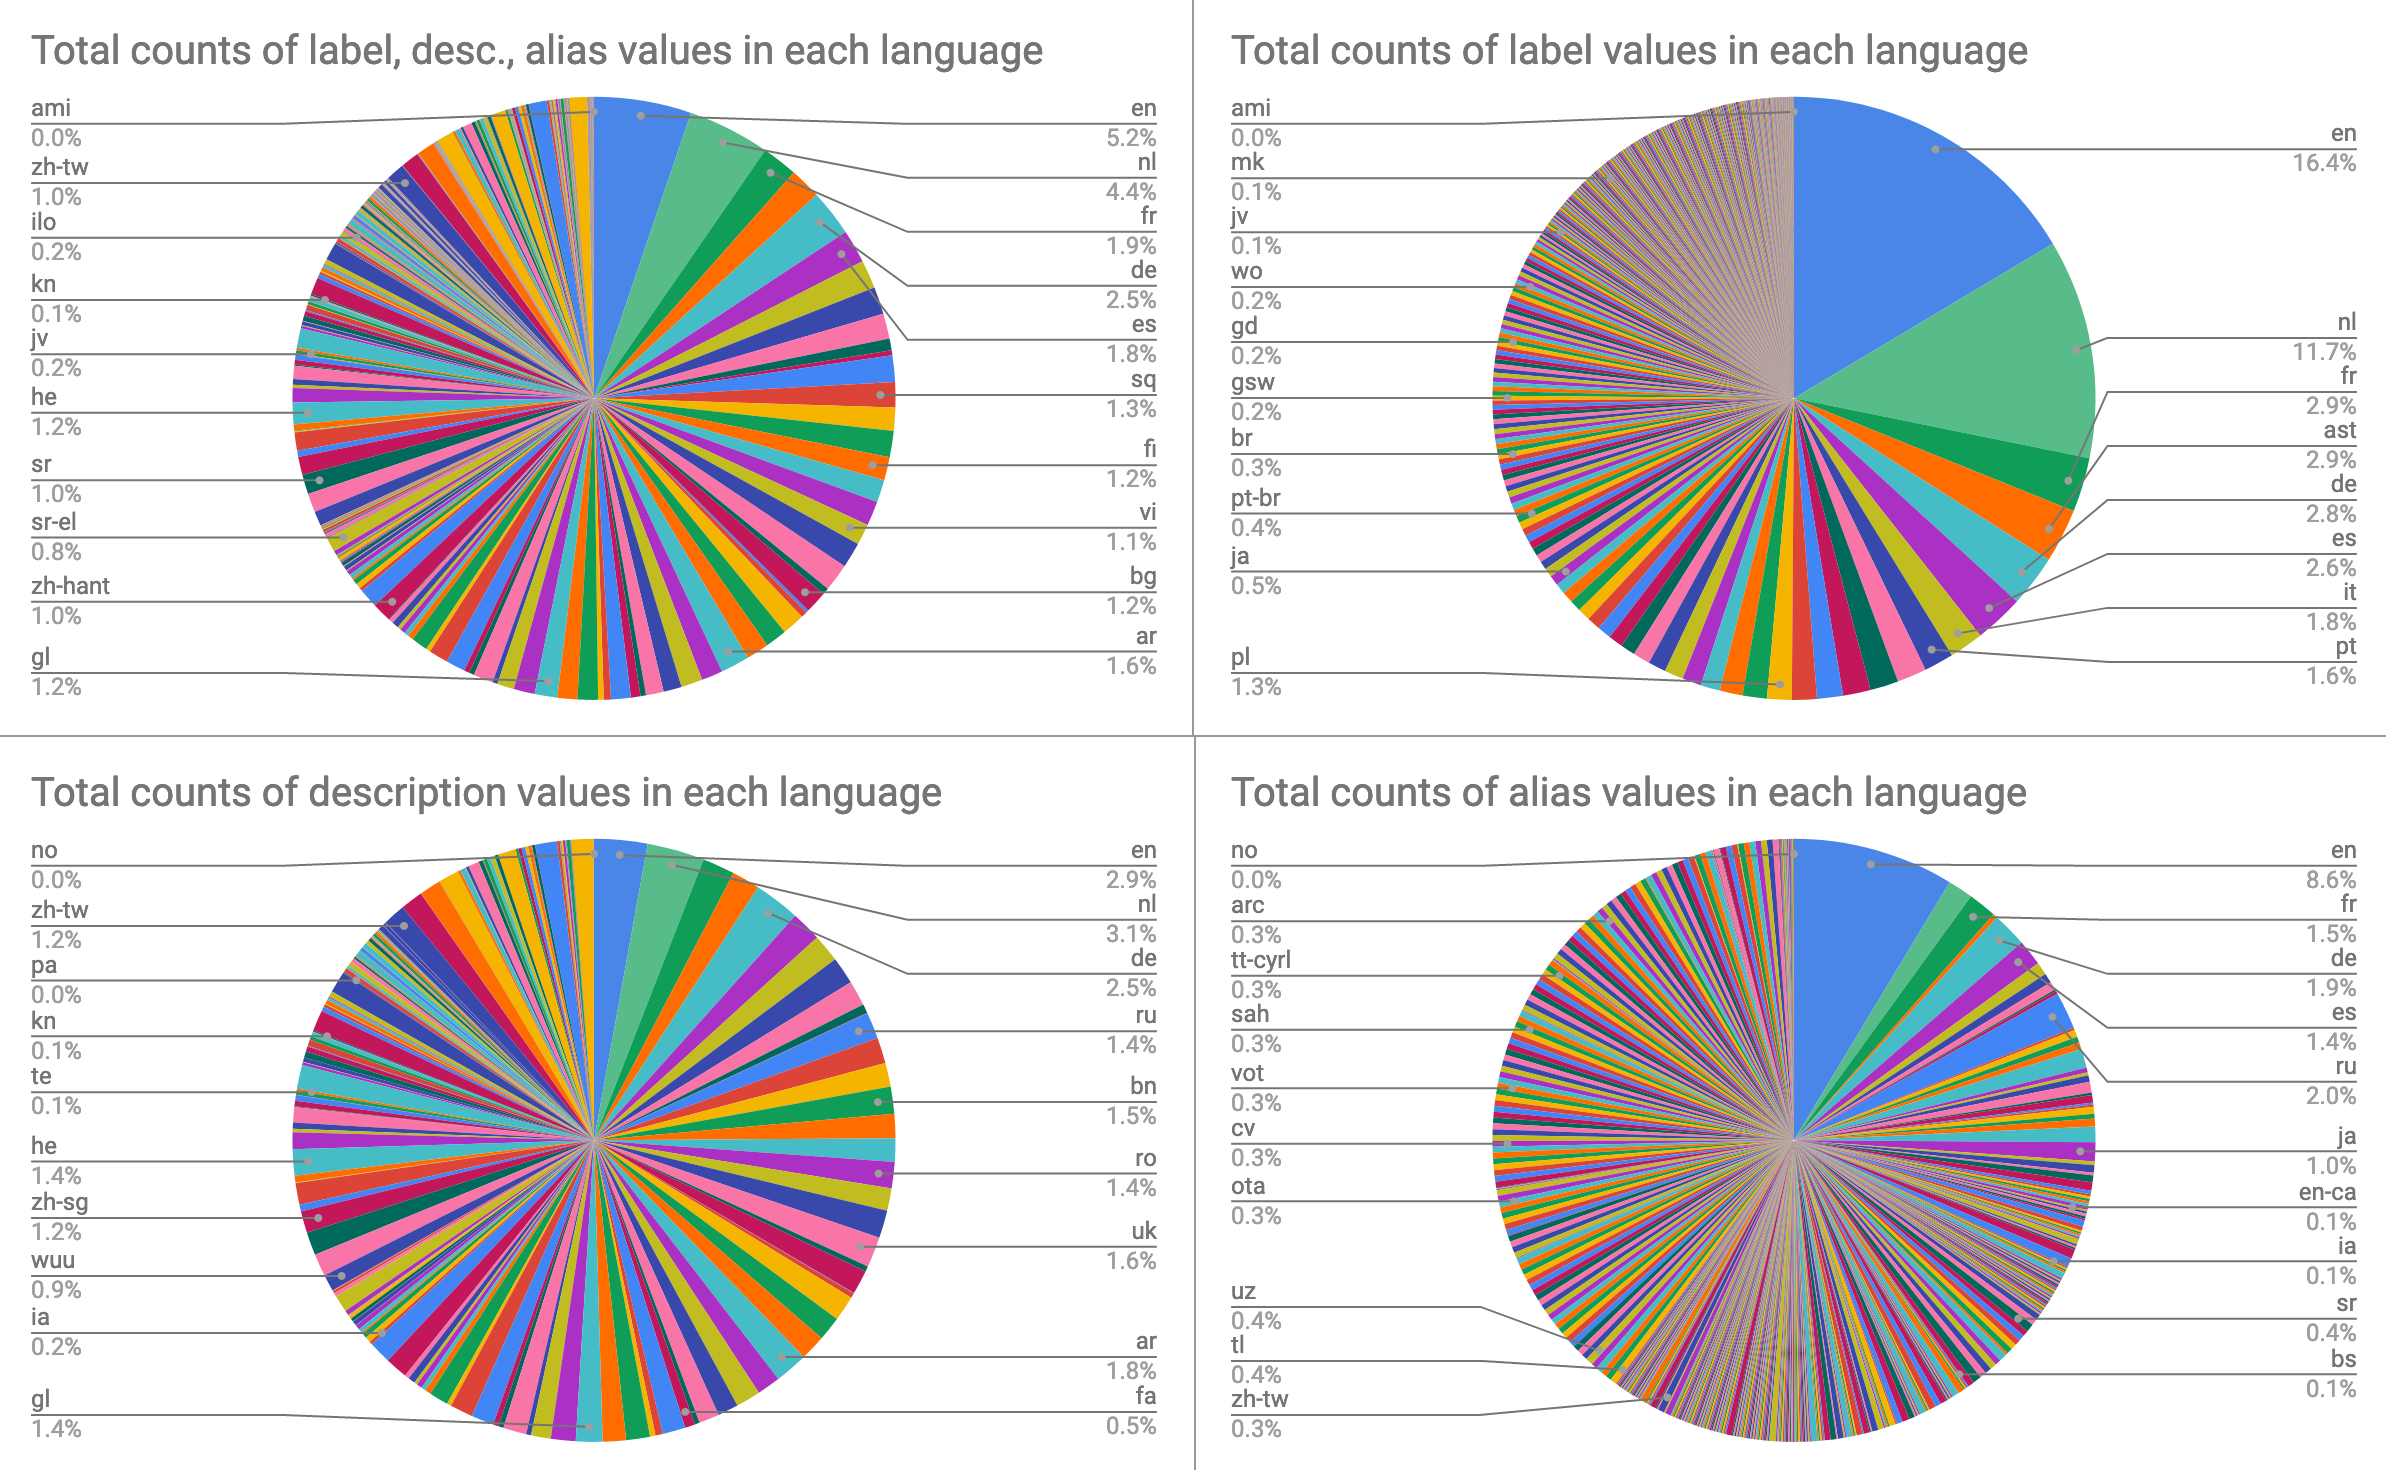

In [10]:
from IPython.display import display
from PIL import Image
# 20210301 Wikidata dump
path="../Screenshot-piechart-lang-distrib.png"
display(Image.open(path))

## ✅ Outputting `label`, `desc`, `alias` `triples` TSVs

In [1]:
# Getting output TSVs of triples for label, desc, alias
import pandas as pd
import json
import os
import gzip
from tqdm import tqdm

def write_triple(outfile, sub, pred, obj):
    with open(outfile, 'a') as f1:
        f1.write("\t".join([sub, pred, obj, ""]) + "\n")

def write_triple_wlang(outfile, sub, pred, obj, lang):
    with open(outfile, 'a') as f1:
        f1.write("\t".join([sub, pred, obj, lang]) + "\n")

output_file_label_en = "wd-triples-label-en.tsv"
output_file_desc_en  = "wd-triples-desc-en.tsv"
output_file_alias_en = "wd-triples-alias-en.tsv"

# file_name = "wikidata-100.json"
# with open(file_name) as txt_file:
#     for line in tqdm(txt_file, total=100):
file_name = "wikidata-20210630-all.json.gz"
with gzip.open(file_name, 'rt') as txt_file:
    for line in tqdm(txt_file, total=93526664):
        try:
            if line.startswith("{"):
                ln_json = json.loads(line[:-2])
                if ln_json['type'] == 'item':
                    # id
                    wd_id = ln_json['id']
                    # labels
                    labels = ln_json['labels'].keys()
                    for lang in labels:
                        prop = 'label'
                        if lang == "en":
                            label_val = ln_json['labels'][lang]['value']
                            write_triple_wlang(output_file_label_en, wd_id, "label", label_val, lang)
                    # desc
                    descs = ln_json['descriptions'].keys()
                    for lang2 in descs:
                        prop = 'desc'
                        if lang2 == "en":
                            desc_val = ln_json['descriptions'][lang2]['value']
                            write_triple_wlang(output_file_desc_en, wd_id, prop, desc_val, lang2)
                    # aliases
                    aliases = ln_json['aliases'].keys()
                    for lang3 in aliases:
                        prop = 'alias'
                        if lang3 == "en":
                            aliases_dict = ln_json['aliases'][lang3]
                            for alias in aliases_dict:
                                alias_val = alias['value']
                                write_triple_wlang(output_file_alias_en, wd_id, prop, alias_val, lang3)
        except:
            pass

100%|██████████| 93526664/93526664 [12:26:49<00:00, 2087.19it/s]  


In [9]:
# Getting output TSVs of triples for label, desc, alias - of properties
import pandas as pd
import json
import os
import gzip
from tqdm import tqdm

def write_triple(outfile, sub, pred, obj):
    with open(outfile, 'a') as f1:
        f1.write("\t".join([sub, pred, obj, ""]) + "\n")

def write_triple_wlang(outfile, sub, pred, obj, lang):
    with open(outfile, 'a') as f1:
        f1.write("\t".join([sub, pred, obj, lang]) + "\n")

output_file_label_en = "wd-triples-props-label-en.tsv"
output_file_desc_en  = "wd-triples-props-desc-en.tsv"
output_file_alias_en = "wd-triples-props-alias-en.tsv"

# file_name = "wikidata-100.json"
# with open(file_name) as txt_file:
#     for line in tqdm(txt_file, total=100):
file_name = "wikidata-20210630-all.json.gz"
with gzip.open(file_name, 'rt') as txt_file:
    for line in tqdm(txt_file, total=93526664):
        try:
            if line.startswith("{"):
                ln_json = json.loads(line[:-2])
                if ln_json['type'] != 'item':  # property, or any other
                    # id
                    wd_id = ln_json['id']
                    # labels
                    labels = ln_json['labels'].keys()
                    for lang in labels:
                        prop = 'label'
                        if lang == "en":
                            label_val = ln_json['labels'][lang]['value']
                            write_triple_wlang(output_file_label_en, wd_id, "label", label_val, lang)
                    # desc
                    descs = ln_json['descriptions'].keys()
                    for lang2 in descs:
                        prop = 'desc'
                        if lang2 == "en":
                            desc_val = ln_json['descriptions'][lang2]['value']
                            write_triple_wlang(output_file_desc_en, wd_id, prop, desc_val, lang2)
                    # aliases
                    aliases = ln_json['aliases'].keys()
                    for lang3 in aliases:
                        prop = 'alias'
                        if lang3 == "en":
                            aliases_dict = ln_json['aliases'][lang3]
                            for alias in aliases_dict:
                                alias_val = alias['value']
                                write_triple_wlang(output_file_alias_en, wd_id, prop, alias_val, lang3)
        except:
            pass

100%|██████████| 93526664/93526664 [5:27:38<00:00, 4757.52it/s]   


In [2]:
# import pandas as pd
# from tqdm import tqdm

# label_en_INPUT = {'sub': [], 'obj': []}
# with open('wd-triples-label-en.tsv') as f1:
#     for row in tqdm(f1, total=78588100):
#         srow = row.split('\t')
#         label_en_INPUT['sub'].append(srow[0])
#         # label_en['pred'].append(srow[1])
#         label_en_INPUT['obj'].append(srow[2])

# IF running the next cell after this ---- But iterations take too long - not usable
# label_en = pd.DataFrame.from_dict(label_en_INPUT)
# temp = P31_obj_counts2[ P31_obj_counts2['P31_obj_set'].str.contains(",") ]
# for indx, row in tqdm(temp.iterrows(), total=temp.shape[0]):
#     P31_obj_set = row['P31_obj_set']
#     sets = P31_obj_set.split(", ")
#     if len(sets) > 1:
#         labels = []
#         for st in sets:
#             try:
#                 label = list(label_en[label_en['sub'] == st]['obj'])[0]
#                 labels.append(label)
#             except:
#                 labels.append("N/A")
#         temp.at[indx, 'label_en'] = ", ".join(labels)

78588100it [01:09, 1130703.17it/s]                              


## ✅ Adding `label` and `desc` to `P31_obj_set` TSVs

### 🇺🇸🇨🇦🇬🇧 EN only

In [1]:
# Create wd-counts-P31-obj-sets-wlabel-en.tsv file - Add label
import pandas as pd
from tqdm import tqdm

label_en = pd.read_csv('wd-triples-label-en.tsv', sep='\t', names=['sub', 'pred', 'obj', 'lang'])
P31_obj_counts = pd.read_csv('wd-counts-P31-obj-sets.tsv', sep='\t')

# Iterate over P31_obj_sets and ensure each unique obj is added 
# => 100%|██████████| 232664/232664
# NEXT: populates the labels/desc in next code cell
all_P31_objs = []
for indx, row in tqdm(P31_obj_counts.iterrows(), total=P31_obj_counts.shape[0]):
    P31_obj_set = row['P31_obj_set']
    sets = P31_obj_set.split(", ")
    if len(sets) > 1:
        for st in sets:
            if st not in all_P31_objs:
                all_P31_objs.append(st)
# Adding as "0" count P31_obj_set rows - adding sets for completeness
# => 100%|██████████| 52143/52143 <= Number of unique obj: {p1, p2, pN} in set in Sets
for obj in tqdm(all_P31_objs, total=len(all_P31_objs)):
    if obj not in P31_obj_counts.values:
        P31_obj_counts = P31_obj_counts.append({'P31_obj_set': obj,'P31_obj_sets_counts': 0},
                              ignore_index=True)

P31_obj_counts2 = pd.merge(P31_obj_counts, label_en, how='left', left_on='P31_obj_set', right_on='sub')
P31_obj_counts2 = P31_obj_counts2.drop(columns=['sub', 'pred', 'lang'])
P31_obj_counts2.rename(columns={'obj':'label_en'}, inplace=True) 

P31_obj_counts2.to_csv('wd-counts-P31-obj-sets-wlabel-en.tsv', sep='\t', index=False)
P31_obj_counts2
# Original rows + "0" count rows = Resulting rows  == 232_664 + 24_673 = 257_337

100%|██████████| 52143/52143 [27:15<00:00, 31.88it/s]


P31_obj_set  \
0                               Q331769, Q60539479, Q9415   
1                                                      Q5   
2                                    Q15632617, Q15773317   
3       Q15633582, Q33002955, Q33120876, Q35127, Q3650...   
4                              Q20181813, Q3624078, Q6256   
...                                                   ...   
257332                                           Q5097678   
257333                                          Q61377117   
257334                                           Q1301235   
257335                                            Q366580   
257336                                          Q96097957   

        P31_obj_sets_counts  P31_obj_sets_asobj  \
0                         1                 5.0   
1                   9185307           7772554.0   
2                      6488               803.0   
3                         1                86.0   
4                         1             49865.0   
...                     ...                 ...   
257332                    0                 NaN   
257333                    0                 NaN   
257334                    0                 NaN   
257335                    0                 NaN   
257336                    0                 NaN   

                                   label_en  
0                                       NaN  
1                                     human  
2                                       NaN  
3                                       NaN  
4                                       NaN  
...                                     ...  
257332  Child: Care, Health and Development  
257333                                  NaN  
257334                                  NaN  
257335                    technical support  
257336                               coffer  

[257337 rows x 4 columns]

In [2]:
# Create wd-counts-P31-obj-sets-wlabel-wdesc-en.tsv file - Add desc
import pandas as pd

desc_en = pd.read_csv('wd-triples-desc-en.tsv', sep='\t', names=['sub', 'pred', 'obj', 'lang'])
P31_obj_counts2 = pd.read_csv('wd-counts-P31-obj-sets-wlabel-en.tsv', sep='\t')

P31_obj_counts3 = pd.merge(P31_obj_counts2, desc_en, how='left', left_on='P31_obj_set', right_on='sub')
P31_obj_counts3 = P31_obj_counts3.drop(columns=['sub', 'pred', 'lang'])
P31_obj_counts3.rename(columns={'obj':'desc_en'}, inplace=True)

P31_obj_counts3 = P31_obj_counts3.sort_values(by='P31_obj_sets_counts', ascending=False)
P31_obj_counts3.to_csv('wd-counts-P31-obj-sets-wlabel-wdesc-en.tsv', sep='\t', index=False)
P31_obj_counts3

P31_obj_set  P31_obj_sets_counts  P31_obj_sets_asobj  \
26285         Q13442814             34336365            170306.0   
1                    Q5              9185307           7772554.0   
190            Q4167836              4821278            598595.0   
11               Q16521              2956745           4603491.0   
2274    Q523, Q67206691              2426282              1835.0   
...                 ...                  ...                 ...   
240885         Q3983735                    0                 NaN   
240884           Q19033                    0                 NaN   
240883          Q299802                    0                 NaN   
240882        Q24699540                    0                 NaN   
257336        Q96097957                    0                 NaN   

                                          label_en  \
26285                            scholarly article   
1                                            human   
190                             Wikimedia category   
11                                           taxon   
2274                                           NaN   
...                                            ...   
240885                              Tennislife Cup   
240884                             arithmetic mean   
240883                               Tel Aviv Open   
240882  Australian Hard Court Tennis Championships   
257336                                      coffer   

                                                  desc_en  
26285   article in an academic publication, usually pe...  
1       common name of Homo sapiens, unique extant spe...  
190     use with 'instance of' (P31) for Wikimedia cat...  
11      group of one or more organism(s), which a taxo...  
2274                                                  NaN  
...                                                   ...  
240885                                                NaN  
240884  sum of a collection of numbers divided by the ...  
240883                                  tennis tournament  
240882                                                NaN  
257336  small type of chest for storing valuables serv...  

[257337 rows x 5 columns]

In [4]:
# Create wd-counts-P31-obj-sets-wlabel-wdesc-en.tsv file - Add label, desc
# NOTE: Updated to populate >1 obj set rows
from tqdm import tqdm
import pandas as pd

P31_obj_data0 = pd.read_csv('wd-counts-P31-obj-sets-wlabel-wdesc-en.tsv', sep='\t')

P31_obj_set_id_label = []
P31_obj_set_label = []
P31_obj_set_label_desc = []
for indx, row in tqdm(P31_obj_data0.iterrows(), total=P31_obj_data0.shape[0]):
    P31_obj_set = row['P31_obj_set']
    id_labels = []
    labels = []
    labels_desc = []
    for obj in P31_obj_set.split(', '):
        try:  ###### Labels #####
            labels.append(str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['label_en'])[0]))
        except:
            labels.append("N/A")
        try:  ##### Qid and Labels #####
            id_label = "(" + str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['P31_obj_set'])[0]) + ") "+\
                       str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['label_en'])[0])
            id_labels.append(id_label)
        except:
            id_labels.append(" - ")
        try:  ##### Labels and Description #####
            text = str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['label_en'])[0]) + " - "+\
                   str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['desc_en'])[0])
            labels_desc.append(text)
        except:
            labels_desc.append(" ")
    P31_obj_set_id_label.append( ", ".join(id_labels) )
    P31_obj_set_label.append( ", ".join(labels) )
    P31_obj_set_label_desc.append( ", ".join(labels_desc) )
# Output
P31_obj_data0['P31_obj_set_id_label'] = P31_obj_set_id_label
P31_obj_data0['P31_obj_set_label'] = P31_obj_set_label
P31_obj_data0['P31_obj_set_label_desc'] = P31_obj_set_label_desc
del P31_obj_data0['label_en'],  P31_obj_data0['desc_en']  # Removed duplicated columns
P31_obj_data0.to_csv('wd-counts-P31-obj-sets-wlabel-wdesc-en.tsv', sep='\t', index=False)
P31_obj_data0

100%|██████████| 257337/257337 [7:56:43<00:00,  9.00it/s]   


P31_obj_set  P31_obj_sets_counts  P31_obj_sets_asobj  \
0             Q13442814             34336365            170306.0   
1                    Q5              9185307           7772554.0   
2              Q4167836              4821278            598595.0   
3                Q16521              2956745           4603491.0   
4       Q523, Q67206691              2426282              1835.0   
...                 ...                  ...                 ...   
257332         Q3983735                    0                 NaN   
257333           Q19033                    0                 NaN   
257334          Q299802                    0                 NaN   
257335        Q24699540                    0                 NaN   
257336        Q96097957                    0                 NaN   

                                     P31_obj_set_id_label  \
0                           (Q13442814) scholarly article   
1                                              (Q5) human   
2                           (Q4167836) Wikimedia category   
3                                          (Q16521) taxon   
4                (Q523) star, (Q67206691) infrared source   
...                                                   ...   
257332                          (Q3983735) Tennislife Cup   
257333                           (Q19033) arithmetic mean   
257334                            (Q299802) Tel Aviv Open   
257335  (Q24699540) Australian Hard Court Tennis Champ...   
257336                                 (Q96097957) coffer   

                                 P31_obj_set_label  \
0                                scholarly article   
1                                            human   
2                               Wikimedia category   
3                                            taxon   
4                            star, infrared source   
...                                            ...   
257332                              Tennislife Cup   
257333                             arithmetic mean   
257334                               Tel Aviv Open   
257335  Australian Hard Court Tennis Championships   
257336                                      coffer   

                                   P31_obj_set_label_desc  
0       scholarly article - article in an academic pub...  
1       human - common name of Homo sapiens, unique ex...  
2       Wikimedia category - use with 'instance of' (P...  
3       taxon - group of one or more organism(s), whic...  
4       star - astronomical object consisting of a lum...  
...                                                   ...  
257332                               Tennislife Cup - nan  
257333  arithmetic mean - sum of a collection of numbe...  
257334                  Tel Aviv Open - tennis tournament  
257335   Australian Hard Court Tennis Championships - nan  
257336  coffer - small type of chest for storing valua...  

[257337 rows x 6 columns]

### 🌐 Multilingual

In [1]:
# len(P31_obj_sets_uniq_Qids) remaining so far: 5000
# 100%|██████████| 93526664/93526664 [55:00:34<00:00, 472.27it/s]   
import pandas as pd
import json
import gzip
from tqdm import tqdm

def count_update(global_dict, key_tocheck, update_val):
    """ Update count in dict if key value present, using globals """
    if key_tocheck not in global_dict:
        global_dict[key_tocheck] = update_val
    elif key_tocheck in global_dict:
        global_dict[key_tocheck] += update_val

def count_update_str(global_dict, key_tocheck, update_val):
    """ Update string value in dict if key value present, using globals """
    if key_tocheck not in global_dict:
        global_dict[key_tocheck] = update_val
    if key_tocheck in global_dict and global_dict[key_tocheck] != update_val:
        global_dict[key_tocheck] += ", " + update_val

def count_update_nested(global_dict, key_tocheck1, key_tocheck2, update_val):
    """ Update count in dict if key value present, using globals """
    if key_tocheck1 not in global_dict:
        global_dict[key_tocheck1] = {key_tocheck2: update_val}
    elif key_tocheck1 in global_dict and key_tocheck2 not in global_dict[key_tocheck1]:
        global_dict[key_tocheck1][key_tocheck2] = update_val
    elif key_tocheck1 in global_dict and key_tocheck2 in global_dict[key_tocheck1]:
        global_dict[key_tocheck1][key_tocheck2] += update_val
        
def count_update_nested_str(global_dict, key_tocheck1, key_tocheck2, update_val):
    """ Update string value in dict if key value present, using globals """
    if key_tocheck1 not in global_dict:
        global_dict[key_tocheck1] = {key_tocheck2: update_val}
    elif key_tocheck1 in global_dict and key_tocheck2 not in global_dict[key_tocheck1]:
        global_dict[key_tocheck1][key_tocheck2] = update_val
    elif key_tocheck1 in global_dict and key_tocheck2 in global_dict[key_tocheck1]:
        global_dict[key_tocheck1][key_tocheck2] += ", " + update_val


""" # # # # # Getting P31_obj_sets file """
P31_obj_sets_counts = pd.read_csv('wd-counts-P31-obj-sets.tsv', sep='\t')
P31_obj_sets_uniq_Qids = pd.unique(P31_obj_sets_counts['P31_obj_set'].str.split(", ", expand=True).stack())
P31_obj_sets_uniq_Qids = P31_obj_sets_uniq_Qids.tolist()
# P31_obj_sets_uniq_Qids.sort()

# # # # # P31_obj Sets
P31_obj_sets_label_ALL = {}
P31_obj_sets_desc_ALL = {}
P31_obj_sets_alias_ALL = {}

mode = 'prod'  # SET: test, prod
if mode == 'test':
    file_name = "../wikidata-10K.json"
    fileopen = open(file_name)
    total = 10000
if mode == 'prod':
    file_name = "wikidata-20210630-all.json.gz"
    fileopen = gzip.open(file_name, 'rt')
    total = 93526664

    
with fileopen as txt_file:
    for line in tqdm(txt_file, total=total):
        if len(P31_obj_sets_uniq_Qids) > 0:
            try:
                if line.startswith("{"):
                    ln_json = json.loads(line[:-2])
                    # Items
                    if ln_json['type'] == "item":
                        wd_id = ln_json['id']
                        ## Check if item is in P31_obj_sets unique values first:
                        if wd_id in P31_obj_sets_uniq_Qids:
                            # labels
                            labels = ln_json['labels'].keys()
                            for lang1 in labels:
                                label_val = ln_json['labels'][lang1]['value']
                                count_update_nested_str(P31_obj_sets_label_ALL, lang1, wd_id, label_val)
                            # desc
                            descs = ln_json['descriptions'].keys()
                            for lang2 in descs:
                                desc_val = ln_json['descriptions'][lang2]['value']
                                count_update_nested_str(P31_obj_sets_desc_ALL, lang2, wd_id, desc_val)
                            # aliases
                            aliases = ln_json['aliases'].keys()
                            for lang3 in aliases:
                                aliases_dict = ln_json['aliases'][lang3]
                                for alias in aliases_dict:
                                    alias_val = alias['value']
                                    count_update_nested_str(P31_obj_sets_alias_ALL, lang3, wd_id, alias_val)
                        # Remove item from list for faster processing
                        P31_obj_sets_uniq_Qids.remove(wd_id)
                        if len(P31_obj_sets_uniq_Qids) % 5000 == 0:  # log progress
                            print('len(P31_obj_sets_uniq_Qids) remaining so far:', len(P31_obj_sets_uniq_Qids))
            except:
                pass
        else:
            break  # Exit since empty list

""" Output TSVs """
pd_P31_obj_sets_label_ALL = pd.DataFrame.from_dict(P31_obj_sets_label_ALL)
pd_P31_obj_sets_label_ALL.to_csv('wd-Qid-P31-obj-sets-label_ALL.tsv', sep='\t', index_label='P31_obj_set_uniq_Qid')
pd_P31_obj_sets_desc_ALL = pd.DataFrame.from_dict(P31_obj_sets_desc_ALL)
pd_P31_obj_sets_desc_ALL.to_csv('wd-Qid-P31-obj-sets-desc_ALL.tsv', sep='\t', index_label='P31_obj_set_uniq_Qid')
pd_P31_obj_sets_alias_ALL = pd.DataFrame.from_dict(P31_obj_sets_alias_ALL)
pd_P31_obj_sets_alias_ALL.to_csv('wd-Qid-P31-obj-sets-alias_ALL.tsv', sep='\t', index_label='P31_obj_set_uniq_Qid')

  0%|          | 20616/93526664 [01:31<110:47:24, 234.44it/s]

len(P31_obj_sets_uniq_Qids) remaining so far: 80000


  1%|          | 688664/93526664 [49:56<99:27:51, 259.27it/s] 

len(P31_obj_sets_uniq_Qids) remaining so far: 75000


 13%|█▎        | 11708495/93526664 [12:35:47<76:06:06, 298.64it/s] 

len(P31_obj_sets_uniq_Qids) remaining so far: 70000


 13%|█▎        | 12332035/93526664 [13:10:23<71:32:12, 315.28it/s]

len(P31_obj_sets_uniq_Qids) remaining so far: 65000


 25%|██▌       | 23392026/93526664 [24:16:26<52:13:10, 373.08it/s] 

len(P31_obj_sets_uniq_Qids) remaining so far: 60000


 26%|██▌       | 23967730/93526664 [24:43:34<48:55:43, 394.90it/s]

len(P31_obj_sets_uniq_Qids) remaining so far: 55000


 38%|███▊      | 35076989/93526664 [33:13:39<47:53:18, 339.04it/s] 

len(P31_obj_sets_uniq_Qids) remaining so far: 50000


 38%|███▊      | 35646385/93526664 [33:36:35<35:56:33, 447.32it/s]

len(P31_obj_sets_uniq_Qids) remaining so far: 45000


 50%|█████     | 46766404/93526664 [40:31:00<30:31:08, 425.60it/s] 

len(P31_obj_sets_uniq_Qids) remaining so far: 40000


 51%|█████     | 47299589/93526664 [40:52:41<27:58:52, 458.91it/s]

len(P31_obj_sets_uniq_Qids) remaining so far: 35000


 63%|██████▎   | 58454609/93526664 [47:45:58<18:56:01, 514.55it/s]

len(P31_obj_sets_uniq_Qids) remaining so far: 30000


 63%|██████▎   | 58994888/93526664 [47:58:34<12:03:47, 795.17it/s]

len(P31_obj_sets_uniq_Qids) remaining so far: 25000


 75%|███████▌  | 70148092/93526664 [51:40:56<7:54:56, 820.39it/s] 

len(P31_obj_sets_uniq_Qids) remaining so far: 20000


 76%|███████▌  | 70710526/93526664 [51:49:05<4:26:25, 1427.33it/s]

len(P31_obj_sets_uniq_Qids) remaining so far: 15000


 88%|████████▊ | 81841164/93526664 [54:02:11<2:57:19, 1098.29it/s]

len(P31_obj_sets_uniq_Qids) remaining so far: 10000


 88%|████████▊ | 82367316/93526664 [54:06:17<56:45, 3277.12it/s]  

len(P31_obj_sets_uniq_Qids) remaining so far: 5000


100%|██████████| 93526664/93526664 [55:00:34<00:00, 472.27it/s]   


In [1]:
# Join P31_obj_counts with cols of all languages and their labels, desc, alias
import numpy as np
import pandas as pd
from tqdm import tqdm

P31_obj_sets_counts = pd.read_csv('wd-counts-P31-obj-sets.tsv', sep='\t')
pd_P31_obj_sets_label_ALL = pd.read_csv('wd-Qid-P31-obj-sets-label_ALL.tsv', sep='\t', low_memory=False)
pd_P31_obj_sets_label_ALL.index = pd_P31_obj_sets_label_ALL['P31_obj_set_uniq_Qid']
pd_P31_obj_sets_desc_ALL = pd.read_csv('wd-Qid-P31-obj-sets-desc_ALL.tsv', sep='\t', low_memory=False)
pd_P31_obj_sets_desc_ALL.index = pd_P31_obj_sets_desc_ALL['P31_obj_set_uniq_Qid']
pd_P31_obj_sets_alias_ALL = pd.read_csv('wd-Qid-P31-obj-sets-alias_ALL.tsv', sep='\t', low_memory=False)
pd_P31_obj_sets_alias_ALL.index = pd_P31_obj_sets_alias_ALL['P31_obj_set_uniq_Qid']
del pd_P31_obj_sets_label_ALL['P31_obj_set_uniq_Qid'], pd_P31_obj_sets_desc_ALL['P31_obj_set_uniq_Qid'], pd_P31_obj_sets_alias_ALL['P31_obj_set_uniq_Qid']

new_df_label = pd.DataFrame()
new_df_desc = pd.DataFrame()
new_df_alias = pd.DataFrame()

for indx, row in tqdm(P31_obj_sets_counts.iterrows(), total=P31_obj_sets_counts.shape[0]):
    P31_obj_set = row['P31_obj_set']
    series_label, series_desc, series_alias = None, None, None
    skip_label, skip_desc, skip_alias = False, False, False
    for obj in P31_obj_set.split(", "):
        ###### Labels #####
        if series_label is not None:
            try:
                series_label += ", " + pd_P31_obj_sets_label_ALL.loc[obj]
            except:
                pass
        if series_label is None:
            try:
                series_label = pd_P31_obj_sets_label_ALL.loc[obj]
            except:
                series_label = pd_P31_obj_sets_label_ALL.loc['Q5']  # any common item
                series_label2 = pd.DataFrame(series_label).T
                series_label2.index = [P31_obj_set]
                series_label2 = series_label2.replace(r'.+', np.NaN, regex=True)
                new_df_label = new_df_label.append(series_label2)
                skip_label = True
        ###### Desc #####
        if series_desc is not None:
            try:
                series_desc += ", " + pd_P31_obj_sets_desc_ALL.loc[obj]
            except:
                pass
        if series_desc is None:
            try:
                series_desc = pd_P31_obj_sets_desc_ALL.loc[obj]
            except:
                series_desc = pd_P31_obj_sets_desc_ALL.loc['Q5']
                series_desc2 = pd.DataFrame(series_desc).T
                series_desc2.index = [P31_obj_set]
                series_desc2 = series_desc2.replace(r'.+', np.NaN, regex=True)
                new_df_desc = new_df_desc.append(series_desc2)
                skip_desc = True
        ###### Alias #####
        if series_alias is not None:
            try:
                series_alias += ", " + pd_P31_obj_sets_alias_ALL.loc[obj]
            except:
                pass
        if series_alias is None:
            try:
                series_alias = pd_P31_obj_sets_alias_ALL.loc[obj]
            except:
                series_alias = pd_P31_obj_sets_alias_ALL.loc['Q5']
                series_alias2 = pd.DataFrame(series_alias).T
                series_alias2.index = [P31_obj_set]
                series_alias2 = series_alias2.replace(r'.+', np.NaN, regex=True)
                new_df_alias = new_df_alias.append(series_alias2)
                skip_alias = True
                
    # df operations
    if skip_label == False:
        series_label2 = pd.DataFrame(series_label).T
        series_label2.index = [P31_obj_set]
        new_df_label = new_df_label.append(series_label2)
    if skip_desc == False:
        series_desc2 = pd.DataFrame(series_desc).T
        series_desc2.index = [P31_obj_set]
        new_df_desc = new_df_desc.append(series_desc2)
    if skip_alias == False:
        series_alias2 = pd.DataFrame(series_alias).T
        series_alias2.index = [P31_obj_set]
        new_df_alias = new_df_alias.append(series_alias2)

# Saving TSVs
for df, df_name in [(new_df_label, 'wd-counts-P31-obj-sets-wlabel-ALL.tsv'),
                    (new_df_desc, 'wd-counts-P31-obj-sets-wdesc-ALL.tsv'),
                    (new_df_alias, 'wd-counts-P31-obj-sets-walias-ALL.tsv') ]:
    # Faster iterative processing
    df.index.name = 'P31_obj_set'
    df = pd.merge(df, P31_obj_sets_counts, left_index=True, right_on='P31_obj_set')
    df.index = df['P31_obj_set']

    COLS = df.columns.tolist() # Reorder rows for readability
    COLS = [c for c in COLS if c not in ('P31_obj_set', 'P31_obj_sets_counts', 'P31_obj_sets_asobj')]
    COLS = ['P31_obj_set', 'P31_obj_sets_counts', 'P31_obj_sets_asobj'] + COLS
    df = df[ COLS ]
    df.to_csv(df_name, sep='\t', index=False)

100%|██████████| 232664/232664 [84:46:12<00:00,  1.31s/it]   


In [2]:
new_df_label

en  \
P31_obj_set                                                                                             
Q331769, Q60539479, Q9415                                             mood, positive emotion, emotion   
Q5                                                                                              human   
Q15632617, Q15773317                                            fictional human, television character   
Q15633582, Q33002955, Q33120876, Q35127, Q36509...  MediaWiki website, knowledge graph, Wikimedia ...   
Q20181813, Q3624078, Q6256                                   colonial power, sovereign state, country   
...                                                                                               ...   
Q107361811                                                   Asia Road Race Championship Sentul Round   
Q1656682, Q1898184                                                                  event, dedication   
Q28020127, Q81113235                                                          fictional humanoid, SCP   
Q23955632, Q39614                                                     Catholic organization, cemetery   
Q1630279, Q327197                                                        guideline, legal transaction   

                                                                                                   fr  \
P31_obj_set                                                                                             
Q331769, Q60539479, Q9415                                           humeur, émotion positive, émotion   
Q5                                                                                        être humain   
Q15632617, Q15773317                                être humain de fiction, personnage de série té...   
Q15633582, Q33002955, Q33120876, Q35127, Q36509...  site MediaWiki, graphe de connaissances, proje...   
Q20181813, Q3624078, Q6256                                  puissance coloniale, État souverain, pays   
...                                                                                               ...   
Q107361811                                                                                        NaN   
Q1656682, Q1898184                                                                événement, dédicace   
Q28020127, Q81113235                                                        humanoïde de fiction, SCP   
Q23955632, Q39614                                                  organisation catholique, cimetière   
Q1630279, Q327197                                   recommandations de bonne pratique, acte juridique   

                                                                                         eo  \
P31_obj_set                                                                                   
Q331769, Q60539479, Q9415                                   humoro, pozitiva emocio, emocio   
Q5                                                                                     homo   
Q15632617, Q15773317                                fikcia homo, fikciulo en televida serio   
Q15633582, Q33002955, Q33120876, Q35127, Q36509...                                      NaN   
Q20181813, Q3624078, Q6256                             kolonia ŝtato, suverena ŝtato, lando   
...                                                                                     ...   
Q107361811                                                                              NaN   
Q1656682, Q1898184                                                                      NaN   
Q28020127, Q81113235                                                                    NaN   
Q23955632, Q39614                                              katolika organizaĵo, tombejo   
Q1630279, Q327197                                                                       NaN   

                                                                                                   it  \
P31_obj_set               

In [3]:
new_df_desc

en  \
P31_obj_set                                                                                             
Q331769, Q60539479, Q9415                           relatively long lasting emotional, internal an...   
Q5                                                  common name of Homo sapiens, unique extant spe...   
Q15632617, Q15773317                                human being that only exists in fictional work...   
Q15633582, Q33002955, Q33120876, Q35127, Q36509...  website whose software engine is MediaWiki, in...   
Q20181813, Q3624078, Q6256                          country that controls colonies, political orga...   
...                                                                                               ...   
Q107361811                                                                                        NaN   
Q1656682, Q1898184                                  temporary and scheduled happening, like a conf...   
Q28020127, Q81113235                                individual humanoid only appearing in fictiona...   
Q23955632, Q39614                                   organization sharing similar beliefs and goals...   
Q1630279, Q327197                                   instruction as to the preferred, recommended, ...   

                                                                                                   it  \
P31_obj_set                                                                                             
Q331769, Q60539479, Q9415                           stato emotivo, tipo di emozione, stato mentale...   
Q5                                                            specie a cui appartiene il genere umano   
Q15632617, Q15773317                                                                              NaN   
Q15633582, Q33002955, Q33120876, Q35127, Q36509...                                                NaN   
Q20181813, Q3624078, Q6256                          Paese che controlla delle colonie, organizzazi...   
...                                                                                               ...   
Q107361811                                                                                        NaN   
Q1656682, Q1898184                                                                                NaN   
Q28020127, Q81113235                                                                              NaN   
Q23955632, Q39614                                                                                 NaN   
Q1630279, Q327197                                                                                 NaN   

                                                                                                   pl  \
P31_obj_set                                                                                             
Q331769, Q60539479, Q9415                           zabarwienie emocjonalne przeżyć, emocja o pozy...   
Q5                                                  nazwa zwyczajowa Homo sapiens, unikalny nadal ...   
Q15632617, Q15773317                                                                              NaN   
Q15633582, Q33002955, Q33120876, Q35127, Q36509...                                                NaN   
Q20181813, Q3624078, Q6256                          państwo, które posiada kolonie, państwo posiad...   
...                                                                                               ...   
Q107361811                                                                                        NaN   
Q1656682, Q1898184                                                                                NaN   
Q28020127, Q81113235                                                                              NaN   
Q23955632, Q39614                                                                                 NaN   
Q1630279, Q327197                                                                                 NaN   

 

In [4]:
new_df_alias

zh-hant zh-hans  \
P31_obj_set                                                                 
Q331769, Q60539479, Q9415                                     NaN     NaN   
Q5                                                          智人, 人   智人, 人   
Q15632617, Q15773317                                          NaN     NaN   
Q15633582, Q33002955, Q33120876, Q35127, Q36509...            NaN     NaN   
Q20181813, Q3624078, Q6256                                    NaN     NaN   
...                                                           ...     ...   
Q107361811                                                    NaN     NaN   
Q1656682, Q1898184                                            NaN     NaN   
Q28020127, Q81113235                                虛構類人類, 虛構類人生物     NaN   
Q23955632, Q39614                                             NaN     NaN   
Q1630279, Q327197                                             NaN     NaN   

                                                   zh-cn  zh-sg zh-my  zh-hk  \
P31_obj_set                                                                    
Q331769, Q60539479, Q9415                            NaN    NaN   NaN    NaN   
Q5                                                     人  智人, 人     人  智人, 人   
Q15632617, Q15773317                                 NaN    NaN   NaN    NaN   
Q15633582, Q33002955, Q33120876, Q35127, Q36509...   NaN    NaN   NaN    NaN   
Q20181813, Q3624078, Q6256                           NaN    NaN   NaN    NaN   
...                                                  ...    ...   ...    ...   
Q107361811                                           NaN    NaN   NaN    NaN   
Q1656682, Q1898184                                   NaN    NaN   NaN    NaN   
Q28020127, Q81113235                                 NaN    NaN   NaN    NaN   
Q23955632, Q39614                                    NaN    NaN   NaN    NaN   
Q1630279, Q327197                                    NaN    NaN   NaN    NaN   

                                                            zh-tw  zh-mo  \
P31_obj_set                                                                
Q331769, Q60539479, Q9415                                     NaN    NaN   
Q5                                                              人  智人, 人   
Q15632617, Q15773317                                          NaN    NaN   
Q15633582, Q33002955, Q33120876, Q35127, Q36509...            NaN    NaN   
Q20181813, Q3624078, Q6256                                    NaN    NaN   
...                                                           ...    ...   
Q107361811                                                    NaN    NaN   
Q1656682, Q1898184                                            NaN    NaN   
Q28020127, Q81113235                                虛構類人生物, 虛構類人類    NaN   
Q23955632, Q39614                                             NaN    NaN   
Q1630279, Q327197                                             NaN    NaN   

                                                                                    zh  \
P31_obj_set                                                                              
Q331769, Q60539479, Q9415                                                          NaN   
Q5                                                                               人类, 人   
Q15632617, Q15773317                                虚构人物, 虛構人類, 虚构人类, 電視人物, 电视人物, 电视角色   
Q15633582, Q33002955, Q33120876, Q35127, Q36509...                                 NaN   
Q20181813, Q3624078, Q6256                                                         NaN   
...                                                                                ...   
Q107361811                                                                         NaN   
Q1656682, Q1898184                                                                 NaN   
Q28020127, Q81113235                                                               NaN   
Q23955632, Q39614                   

## ✅ Processing `wd-counts-P31-obj-sets-xlabel-` TSV
- DataFrame: `P31_obj_set x Langs` 
- Values: `count(label)`

In [1]:
# Add label + desc string as a column to P31_obj_sets dataframe
from tqdm import tqdm
import pandas as pd

z = pd.read_csv('wd-counts-P31-obj-sets-xlabel.tsv', sep='\t').fillna(0.1)  # for log-scale calcs
P31_obj_data0 = pd.read_csv('wd-counts-P31-obj-sets-wlabel-wdesc-en.tsv', sep='\t')

P31_obj_set_id_label = []
P31_obj_set_label = []
P31_obj_set_label_desc = []
for indx, row in tqdm(z.iterrows(), total=z.shape[0]):
    P31_obj_set = row['P31_obj_set']
    id_labels = []
    labels = []
    labels_desc = []
    for obj in P31_obj_set.split(', '):
        try:  ###### Labels #####
            labels.append(str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['label_en'])[0]))
        except:
            labels.append("N/A")
        try:  ##### Qid and Labels #####
            id_label = "(" + str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['P31_obj_set'])[0]) + ") "+\
                       str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['label_en'])[0])
            id_labels.append(id_label)
        except:
            id_labels.append(" - ")
        try:  ##### Labels and Description #####
            text = str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['label_en'])[0]) + " - "+\
                   str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['desc_en'])[0])
            labels_desc.append(text)
        except:
            labels_desc.append(" ")
    P31_obj_set_id_label.append( ", ".join(id_labels) )
    P31_obj_set_label.append( ", ".join(labels) )
    P31_obj_set_label_desc.append( ", ".join(labels_desc) )
# Output
z['P31_obj_set_id_label'] = P31_obj_set_id_label
z['P31_obj_set_label'] = P31_obj_set_label
z['P31_obj_set_label_desc'] = P31_obj_set_label_desc
z.to_csv('wd-counts-P31-obj-sets-xlabel-wlabel-wdesc.tsv', sep='\t', index=False)
z

100%|██████████| 232664/232664 [7:28:15<00:00,  8.65it/s]   


P31_obj_set         en  \
0                               Q331769, Q60539479, Q9415        1.0   
1                                                      Q5  8665463.0   
2                                    Q15632617, Q15773317     5535.0   
3       Q15633582, Q33002955, Q33120876, Q35127, Q3650...        1.0   
4                              Q20181813, Q3624078, Q6256        1.0   
...                                                   ...        ...   
232659                                          Q93740491        0.1   
232660                                            Q943055        0.1   
232661                                          Q95685937        0.1   
232662                                          Q95798941        0.1   
232663                                          Q96310233        0.1   

               fr        eo         it        pl        ru         de  \
0             1.0       1.0        1.0       1.0       1.0        1.0   
1       3360545.0  233288.0  2049360.0  831039.0  887514.0  3299107.0   
2          2250.0     144.0     1466.0     594.0    1302.0     1741.0   
3             1.0       1.0        1.0       1.0       1.0        1.0   
4             1.0       1.0        1.0       1.0       1.0        1.0   
...           ...       ...        ...       ...       ...        ...   
232659        0.1       0.1        0.1       0.1       0.1        0.1   
232660        0.1       0.1        0.1       0.1       0.1        0.1   
232661        0.1       0.1        0.1       0.1       0.1        0.1   
232662        0.1       0.1        0.1       0.1       0.1        0.1   
232663        0.1       0.1        0.1       0.1       0.1        0.1   

           en-gb         nb  ...  kcg   no  shy  dua  wls  tly-cyrl   bh  \
0            1.0        1.0  ...  0.1  0.1  0.1  0.1  0.1       0.1  0.1   
1       213075.0  1297728.0  ...  0.1  1.0  1.0  0.1  1.0       0.1  1.0   
2          244.0      703.0  ...  0.1  0.1  0.1  0.1  0.1       0.1  0.1   
3            1.0        1.0  ...  0.1  0.1  0.1  0.1  0.1       0.1  0.1   
4            1.0        1.0  ...  0.1  0.1  0.1  0.1  0.1       0.1  0.1   
...          ...        ...  ...  ...  ...  ...  ...  ...       ...  ...   
232659       0.1        0.1  ...  0.1  0.1  0.1  0.1  0.1       0.1  0.1   
232660       0.1        0.1  ...  0.1  0.1  0.1  0.1  0.1       0.1  0.1   
232661       0.1        0.1  ...  0.1  0.1  0.1  0.1  0.1       0.1  0.1   
232662       0.1        0.1  ...  0.1  0.1  0.1  0.1  0.1       0.1  0.1   
232663       0.1        0.1  ...  0.1  0.1  0.1  0.1  0.1       0.1  0.1   

                                     P31_obj_set_id_label  \
0       (Q331769) mood, (Q60539479) positive emotion, ...   
1                                              (Q5) human   
2       (Q15632617) fictional human, (Q15773317) telev...   
3       (Q15633582) MediaWiki website, (Q33002955) kno...   
4       (Q20181813) colonial power, (Q3624078) soverei...   
...                                                   ...   
232659      (Q93740491) entity obsoleted in Gene Ontology   
232660                           (Q943055) Lula oil field   
232661                                  (Q95685937) flask   
232662                            (Q95798941) incense box   
232663                (Q96310233) front-sheltered lean-to   

                                        P31_obj_set_label  \
0                         mood, positive emotion, emotion   
1                                                   human   
2                   fictional human, television character   
3       MediaWiki website, knowledge graph, Wikimedia ...   
4                colonial power, sovereign state, country   
...                                                   ...   
232659                  entity obsoleted in Gene Ontology   
232660                                     Lula oil field   
232661                                              flask   
232662                                        in

## ✅ Processing `wd-counts-P31-obj-sets-xalias-` TSV
- DataFrame: `P31_obj_set x Langs`
- Values: `count(alias)`

In [4]:
# Add label + desc string as a column to P31_obj_sets dataframe
from tqdm import tqdm
import pandas as pd

z = pd.read_csv('wd-counts-P31-obj-sets-xalias.tsv', sep='\t').fillna(0.1)  # for log-scale calcs
P31_obj_data0 = pd.read_csv('wd-counts-P31-obj-sets-wlabel-wdesc-en.tsv', sep='\t')

P31_obj_set_id_label = []
P31_obj_set_label = []
P31_obj_set_label_desc = []
for indx, row in tqdm(z.iterrows(), total=z.shape[0]):
    P31_obj_set = row['P31_obj_set']
    id_labels = []
    labels = []
    labels_desc = []
    for obj in P31_obj_set.split(', '):
        try:  ###### Labels #####
            labels.append(str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['label_en'])[0]))
        except:
            labels.append("N/A")
        try:  ##### Qid and Labels #####
            id_label = "(" + str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['P31_obj_set'])[0]) + ") "+\
                       str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['label_en'])[0])
            id_labels.append(id_label)
        except:
            id_labels.append(" - ")
        try:  ##### Labels and Description #####
            text = str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['label_en'])[0]) + " - "+\
                   str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['desc_en'])[0])
            labels_desc.append(text)
        except:
            labels_desc.append(" ")
    P31_obj_set_id_label.append( ", ".join(id_labels) )
    P31_obj_set_label.append( ", ".join(labels) )
    P31_obj_set_label_desc.append( ", ".join(labels_desc) )
# Output
z['P31_obj_set_id_label'] = P31_obj_set_id_label
z['P31_obj_set_label'] = P31_obj_set_label
z['P31_obj_set_label_desc'] = P31_obj_set_label_desc
z.to_csv('wd-counts-P31-obj-sets-xalias-wlabel-wdesc.tsv', sep='\t', index=False)
z

100%|██████████| 148559/148559 [4:57:11<00:00,  8.33it/s]  


P31_obj_set   zh-hant  zh-hans   zh-cn  \
0                  Q331769, Q60539479, Q9415       2.0      2.0     2.0   
1                                         Q5  153575.0   8779.0  6298.0   
2                       Q15632617, Q15773317      13.0     12.0     5.0   
3                 Q20181813, Q3624078, Q6256       3.0      2.0     2.0   
4                            Q151885, Q39546       1.0      3.0     3.0   
...                                      ...       ...      ...     ...   
148554                                Q47107       0.1      0.1     0.1   
148555                              Q2101494       0.1      0.1     0.1   
148556                              Q3183734       0.1      0.1     0.1   
148557  Q14276458, Q23383, Q3397659, Q537127       0.1      0.1     0.1   
148558                    Q15092344, Q820254       0.1      0.1     0.1   

        zh-sg  zh-my   zh-hk   zh-tw  zh-mo        zh  ...  guc  ryu  nia  \
0         2.0    2.0     2.0     2.0    2.0       2.0  ...  0.1  0.1  0.1   
1       331.0  240.0  1141.0  2435.0  261.0  271036.0  ...  3.0  4.0  0.1   
2         0.1    0.1     1.0     1.0    0.1     122.0  ...  0.1  0.1  0.1   
3         2.0    2.0     2.0     2.0    3.0       3.0  ...  0.1  0.1  0.1   
4         1.0    1.0     1.0     1.0    1.0       2.0  ...  0.1  0.1  0.1   
...       ...    ...     ...     ...    ...       ...  ...  ...  ...  ...   
148554    0.1    0.1     0.1     0.1    0.1       0.1  ...  0.1  0.1  0.1   
148555    0.1    0.1     0.1     0.1    0.1       0.1  ...  0.1  0.1  0.1   
148556    0.1    0.1     0.1     0.1    0.1       0.1  ...  0.1  0.1  0.1   
148557    0.1    0.1     0.1     0.1    0.1       0.1  ...  0.1  0.1  0.1   
148558    0.1    0.1     0.1     0.1    0.1       0.1  ...  0.1  0.1  0.1   

        pwn  dua  nan-hani  zh-classical  \
0       0.1  0.1       0.1           0.1   
1       0.1  0.1       0.1           0.1   
2       0.1  0.1       0.1           0.1   
3       0.1  0.1       0.1           0.1   
4       0.1  0.1       0.1           0.1   
...     ...  ...       ...           ...   
148554  0.1  0.1       0.1           0.1   
148555  0.1  0.1       0.1           0.1   
148556  0.1  0.1       0.1           0.1   
148557  0.1  0.1       0.1           0.1   
148558  0.1  0.1       0.1           0.1   

                                     P31_obj_set_id_label  \
0       (Q331769) mood, (Q60539479) positive emotion, ...   
1                                              (Q5) human   
2       (Q15632617) fictional human, (Q15773317) telev...   
3       (Q20181813) colonial power, (Q3624078) soverei...   
4                        (Q151885) concept, (Q39546) tool   
...                                                   ...   
148554                                    (Q47107) bucket   
148555             (Q2101494) municipality in Switzerland   
148556                  (Q3183734) ethnic group in Africa   
148557  (Q14276458) deck arch bridge, (Q23383) drawbri...   
148558  (Q15092344) urban area in Norway, (Q820254) mi...   

                                        P31_obj_set_label  \
0                         mood, positive emotion, emotion   
1                                                   human   
2                   fictional human, television character   
3                colonial power, sovereign state, country   
4                                           concept, tool   
...                                                   ...   
148554                                             bucket   
148555                        municipality in Switzerland   
148556                             ethnic group in Africa   
148557  deck arch bridge, drawbridge, concrete arch br...   
148558             urban area in Norway, mining community   

                                   P31_obj_set_label_desc  
0       mood - relatively long lasting emotional, inte...  
1       human - common name of Homo sapiens, unique ex...  
2       fictional human - human 

## ✅ Processing `wd-counts-P31-obj-sets-xdesc-` TSV

In [1]:
# Add label + desc string as a column to P31_obj_sets dataframe
from tqdm import tqdm
import pandas as pd

z = pd.read_csv('wd-counts-P31-obj-sets-xdesc.tsv', sep='\t').fillna(0.1)  # for log-scale calcs
P31_obj_data0 = pd.read_csv('wd-counts-P31-obj-sets-wlabel-wdesc-en.tsv', sep='\t')

P31_obj_set_id_label = []
P31_obj_set_label = []
P31_obj_set_label_desc = []
for indx, row in tqdm(z.iterrows(), total=z.shape[0]):
    P31_obj_set = row['P31_obj_set']
    id_labels = []
    labels = []
    labels_desc = []
    for obj in P31_obj_set.split(', '):
        try:  ###### Labels #####
            labels.append(str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['label_en'])[0]))
        except:
            labels.append("N/A")
        try:  ##### Qid and Labels #####
            id_label = "(" + str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['P31_obj_set'])[0]) + ") "+\
                       str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['label_en'])[0])
            id_labels.append(id_label)
        except:
            id_labels.append(" - ")
        try:  ##### Labels and Description #####
            text = str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['label_en'])[0]) + " - "+\
                   str(list(P31_obj_data0[P31_obj_data0['P31_obj_set'] == obj]['desc_en'])[0])
            labels_desc.append(text)
        except:
            labels_desc.append(" ")
    P31_obj_set_id_label.append( ", ".join(id_labels) )
    P31_obj_set_label.append( ", ".join(labels) )
    P31_obj_set_label_desc.append( ", ".join(labels_desc) )
# Output
z['P31_obj_set_id_label'] = P31_obj_set_id_label
z['P31_obj_set_label'] = P31_obj_set_label
z['P31_obj_set_label_desc'] = P31_obj_set_label_desc
z.to_csv('wd-counts-P31-obj-sets-xdesc-wlabel-wdesc.tsv', sep='\t', index=False)
z

100%|██████████| 208583/208583 [6:42:57<00:00,  8.63it/s]   


P31_obj_set         en  \
0                               Q331769, Q60539479, Q9415        1.0   
1                                                      Q5  6933295.0   
2                                    Q15632617, Q15773317     3888.0   
3       Q15633582, Q33002955, Q33120876, Q35127, Q3650...        1.0   
4                              Q20181813, Q3624078, Q6256        1.0   
...                                                   ...        ...   
208578                                   Q44512, Q5256962        0.1   
208579                        Q510023, Q6024707, Q7840353        0.1   
208580                                           Q4423888        0.1   
208581                                Q1749541, Q83818856        0.1   
208582                                  Q20106372, Q23397        0.1   

               it        pl         fr         de        nb         es  \
0             1.0       1.0        1.0        1.0       1.0        1.0   
1       1865448.0  374386.0  2638108.0  2030578.0  367067.0  2705103.0   
2           453.0      60.0     1003.0     2094.0      80.0      652.0   
3             1.0       1.0        1.0        1.0       1.0        1.0   
4             1.0       1.0        1.0        1.0       1.0        1.0   
...           ...       ...        ...        ...       ...        ...   
208578        0.1       0.1        0.1        0.1       0.1        0.1   
208579        0.1       0.1        0.1        0.1       0.1        0.1   
208580        0.1       0.1        0.1        0.1       0.1        0.1   
208581        0.1       0.1        0.1        0.1       0.1        0.1   
208582        0.1       0.1        0.1        0.1       0.1        0.1   

             ko         ca  ...  gom-deva  cps   rn  ug-latn  uz-cyrl   kr  \
0           1.0        1.0  ...       0.1  0.1  0.1      0.1      0.1  0.1   
1       43689.0  1933379.0  ...       0.1  0.1  0.1      0.1      0.1  1.0   
2          94.0       55.0  ...       0.1  0.1  0.1      0.1      0.1  0.1   
3           1.0        1.0  ...       0.1  0.1  0.1      0.1      0.1  0.1   
4           1.0        1.0  ...       0.1  0.1  0.1      0.1      0.1  0.1   
...         ...        ...  ...       ...  ...  ...      ...      ...  ...   
208578      0.1        0.1  ...       0.1  0.1  0.1      0.1      0.1  0.1   
208579      0.1        0.1  ...       0.1  0.1  0.1      0.1      0.1  0.1   
208580      0.1        0.1  ...       0.1  0.1  0.1      0.1      0.1  0.1   
208581      0.1        0.1  ...       0.1  0.1  0.1      0.1      0.1  0.1   
208582      0.1        0.1  ...       0.1  0.1  0.1      0.1      0.1  0.1   

        zh-classical                               P31_obj_set_id_label  \
0                0.1  (Q331769) mood, (Q60539479) positive emotion, ...   
1                0.1                                         (Q5) human   
2                0.1  (Q15632617) fictional human, (Q15773317) telev...   
3                0.1  (Q15633582) MediaWiki website, (Q33002955) kno...   
4                0.1  (Q20181813) colonial power, (Q3624078) soverei...   
...              ...                                                ...   
208578           0.1  (Q44512) epidemic, (Q5256962) dengue fever out...   
208579           0.1  (Q510023) Paiute people, (Q6024707) Indigenous...   
208580           0.1                                    (Q4423888) form   
208581           0.1    (Q1749541) commentary, (Q83818856) grammar book   
208582           0.1                     (Q20106372) nan, (Q23397) lake   

                                        P31_obj_set_label  \
0                         mood, positive emotion, emotion   
1                                                   human   
2                   fictional human, television character   
3       MediaWiki website, knowledge graph, Wikimedia ...   
4                colonial power, sovereign state, country   
...                                                   ...   
208578                    e

## ➡️ Sankey Diagram
- From `wd-counts-P31-obj-sets-wlabel-wdesc-en.xlsx` and https://www.sankeymatic.com/build/

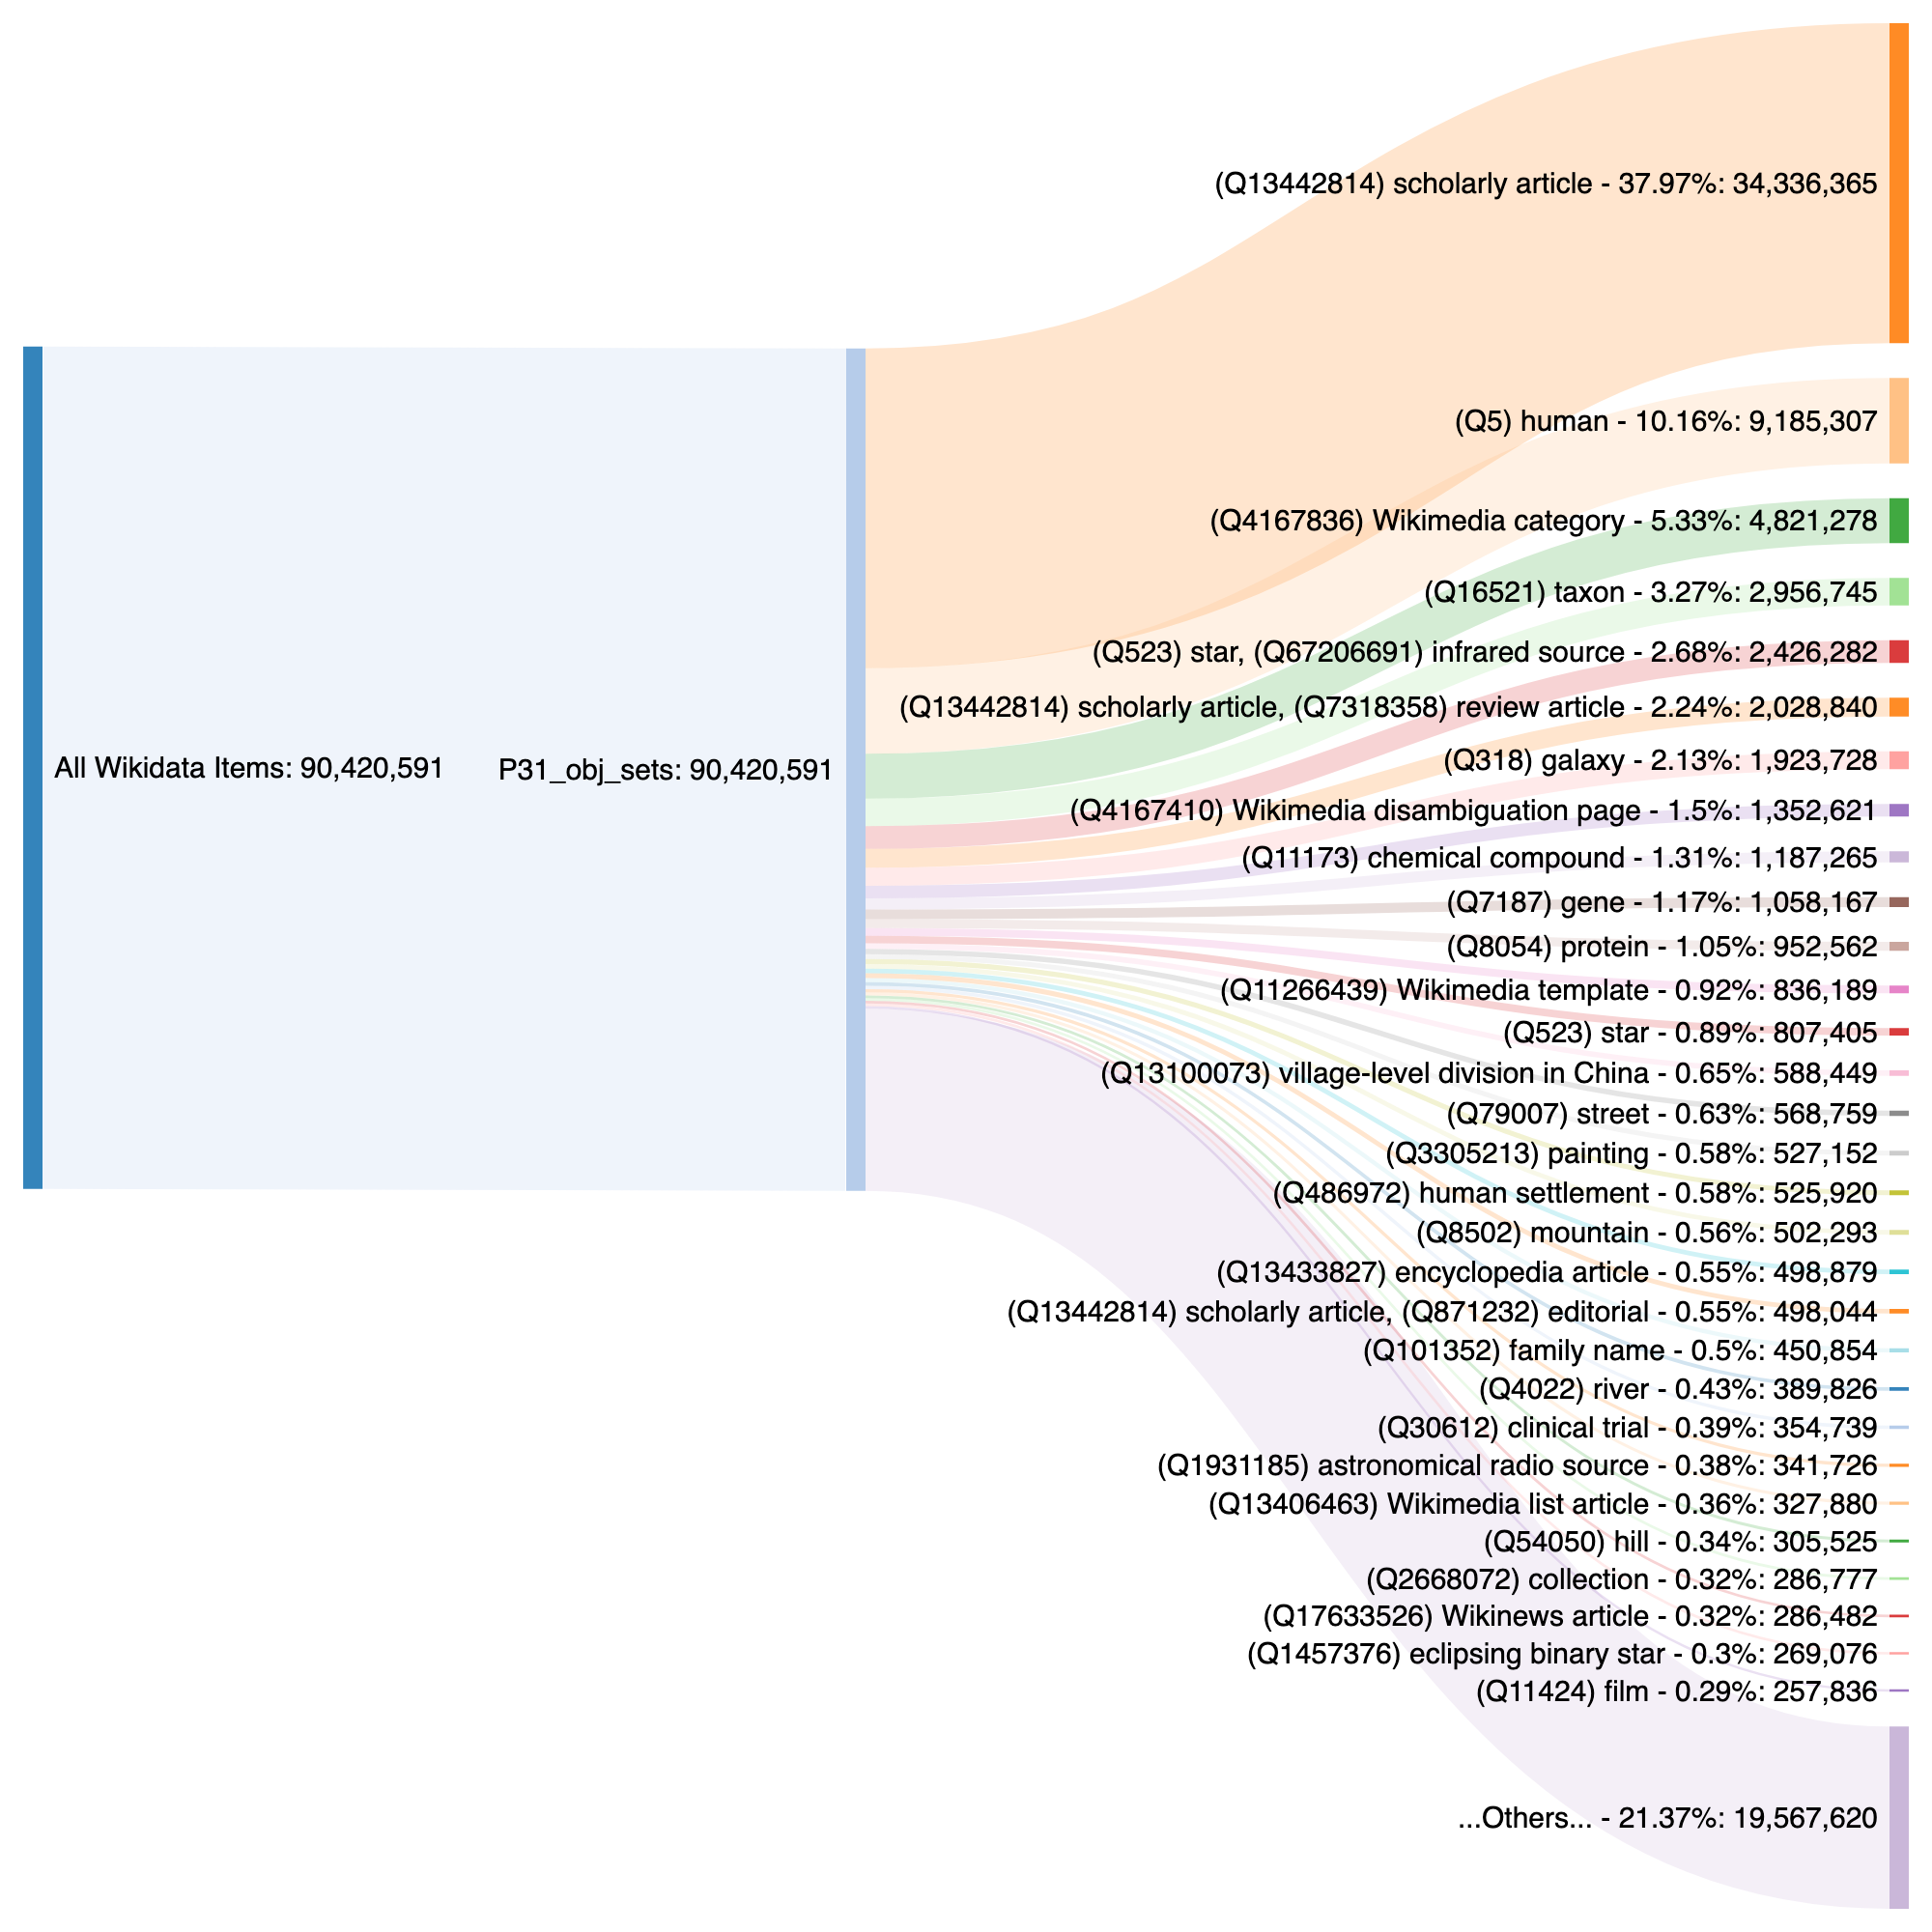

In [1]:
from IPython.display import display
from PIL import Image
# 20210630 Wikidata dump
path="wd-counts-P31-obj-sets-wlabel-wdesc-en-sankeymatic.png"
display(Image.open(path))

# Output Triples

- Generating output triples for training KG embeddings

## ✅ Extracting Triples

In [1]:
# Processing gold1 TSV
import pandas as pd
pd.set_option('max_rows', 100)
pd.set_option('display.max_colwidth', None)

# Data Processing
gdrive = ''
a = pd.read_csv( gdrive + 'wd-counts-P31-obj-sets.tsv', sep='\t')
z = pd.read_csv( gdrive + 'wd-counts-P31-obj-sets-xlabel-wlabel-wdesc.tsv', sep='\t', index_col=0)
z_gold = pd.read_csv( gdrive + '../EXPORT-NLP-P2-300-2500-375-0.714139-pur0.799-gold1.tsv', sep='\t', index_col='P31_obj_set_id_label')
z = pd.merge(z, z_gold['clabel_nlp_stsb-roberta-large_gold1'], left_on='P31_obj_set_id_label', right_index=True)
z2 = pd.merge(z, a, how='inner', left_on='P31_obj_set', right_on='P31_obj_set')
# z2.to_csv('wd-counts-P31-obj-sets-xlabel-wlabel-wdesc-wcluster-NLP-P2-300-2500-375-0.714139-pur0.799-gold1.tsv', sep='\t', index=False)
# z2
z2['clabel_nlp_stsb-roberta-large_gold1'].value_counts() 

administrative district            196
space                              183
public facility, transportation    172
geography                          156
government, legal                  101
sports                              64
religion                            58
architecture                        52
media                               45
biology                             45
written work                        45
wiki                                39
academia                            39
human                               39
music                               36
education                           32
arts, literature                    31
bank                                28
vehicles                            27
military                            23
time, event                         17
fictional work                      15
general                             14
physical object                     12
chemistry                           11
human language           

In [2]:
# academia:
p1 = z2[ z2['clabel_nlp_stsb-roberta-large_gold1'] == 'academia']
print("Sum of P31_obj_sets:", p1['P31_obj_sets_counts'].sum())
p1[['P31_obj_set', 'P31_obj_set_id_label', 'P31_obj_set_label_desc',
       'clabel_nlp_stsb-roberta-large_gold1', 'P31_obj_sets_counts', 'P31_obj_sets_asobj']
   ].sort_values('P31_obj_sets_counts', ascending=False)

Sum of P31_obj_sets: 37242037


P31_obj_set  \
1006                     Q13442814   
1141           Q13442814, Q7318358   
1176            Q13442814, Q871232   
188                       Q5633421   
1180           Q13442814, Q1348305   
1140                       Q187685   
774                      Q18918145   
837                       Q1266946   
829                       Q2467461   
1179  Q13442814, Q7318358, Q871232   
633                       Q2065227   
193                         Q31855   
656                       Q4671277   
1199                     Q23927052   
792               Q737498, Q773668   
1201                      Q1402850   
1258            Q13442814, Q193842   
465                        Q180958   
472                        Q737498   
1164                       Q637866   
777                      Q47258130   
1277           Q1298668, Q54875403   
1121                     Q21481766   
952                      Q45400320   
389     Q5633421, Q737498, Q773668   
1184                      Q1143604   
1212            Q13442814, Q637866   
1192           Q13442814, Q7316896   
1200             Q13442814, Q69488   
1139                     Q17518557   
677                       Q7315155   
510                        Q955824   
959                       Q5341295   
414                       Q2367225   
856                      Q19844914   
1134                     Q55454947   
935              Q5633421, Q737498   
1177          Q13442814, Q45182324   
1237                     Q30749496   

                                                                          P31_obj_set_id_label  \
1006                                                             (Q13442814) scholarly article   
1141                                  (Q13442814) scholarly article, (Q7318358) review article   
1176                                        (Q13442814) scholarly article, (Q871232) editorial   
188                                                              (Q5633421) scientific journal   
1180                                         (Q13442814) scholarly article, (Q1348305) erratum   
1140                                                                 (Q187685) doctoral thesis   
774                                                       (Q18918145) academic journal article   
837                                                                          (Q1266946) thesis   
829                                                             (Q2467461) academic department   
1179             (Q13442814) scholarly article, (Q7318358) review article, (Q871232) editorial   
633                                                                (Q2065227) official journal   
193                                                                (Q31855) research institute   
656                                                            (Q4671277) academic institution   
1199                                                              (Q23927052) conference paper   
792                                  (Q737498) academic journal, (Q773668) open-access journal   
1201                                                                    (Q1402850) field study   
1258                                     (Q13442814) scholarly article, (Q193842) geologic map   
465                                                                          (Q180958) faculty   
472                                                                 (Q737498) academic journal   
1164                                                                     (Q637866) book review   
777                                                   (Q47258130) scientific conference series   
1277                                   (Q1298668) research project, (Q54875403) research grant   
1121                                                              (Q21481766) academic chapter   
952                                                          (Q45400320) open-access publisher   
389   (Q5633421) scientific journal, (Q737498) acade

In [3]:
# space:
p1 = z2[ z2['clabel_nlp_stsb-roberta-large_gold1'] == 'space']
print("Sum of P31_obj_sets:", p1['P31_obj_sets_counts'].sum())
p1[['P31_obj_set', 'P31_obj_set_id_label', 'P31_obj_set_label_desc',
       'clabel_nlp_stsb-roberta-large_gold1', 'P31_obj_sets_counts', 'P31_obj_sets_asobj']
   ].sort_values('P31_obj_sets_counts', ascending=False)

Sum of P31_obj_sets: 8115604


P31_obj_set  \
374       Q523, Q67206691   
229                  Q318   
690                  Q523   
1304             Q1931185   
1351             Q1457376   
...                   ...   
1446      Q523, Q71965638   
1413  Q1457376, Q72534536   
1099    Q24452, Q67206691   
761          Q11276, Q523   
1312      Q318, Q71798788   

                                                          P31_obj_set_id_label  \
374                                   (Q523) star, (Q67206691) infrared source   
229                                                              (Q318) galaxy   
690                                                                (Q523) star   
1304                                      (Q1931185) astronomical radio source   
1351                                          (Q1457376) eclipsing binary star   
...                                                                        ...   
1446                                 (Q523) star, (Q71965638) Seyfert 2 galaxy   
1413  (Q1457376) eclipsing binary star, (Q72534536) eclipsing binary candidate   
1099                      (Q24452) Algol variable, (Q67206691) infrared source   
761                                     (Q11276) globular cluster, (Q523) star   
1312                             (Q318) galaxy, (Q71798788) UV-emission source   

                                                                                                                                                                                               P31_obj_set_label_desc  \
374                                       star - astronomical object consisting of a luminous spheroid of plasma held together by its own gravity, infrared source - astronomical object that produces infrared light   
229                                                                                                                                                                                   galaxy - astronomical structure   
690                                                                                                           star - astronomical object consisting of a luminous spheroid of plasma held together by its own gravity   
1304                                                                                                                                  astronomical radio source - object in outer space that emits strong radio waves   
1351                                    eclipsing binary star - binary star in which the orbit plane of the two stars lies so nearly in the line of sight of the observer that the components undergo mutual eclipses   
...                                                                                                                                                                                                               ...   
1446                                                                                  star - astronomical object consisting of a luminous spheroid of plasma held together by its own gravity, Seyfert 2 galaxy - nan   
1413  eclipsing binary star - binary star in which the orbit plane of the two stars lies so nearly in the line of sight of the observer that the components undergo mutual eclipses, eclipsing binary candidate - nan   
1099                                                                                             Algol variable - class of eclipsing binary stars, infrared source - astronomical object that produces infrared light   
761                                                         globular cluster - spherical collection of stars, star - astronomical object consisting of a luminous spheroid of plasma held together by its own gravity   
1312                                                                                                                                                        galaxy - astronomical structure, UV-emission source - nan   

     clabel_nlp_stsb-roberta-large_gold1  P31_obj_sets_counts  \
374       

In [4]:
# biology:
p1 = z2[ z2['clabel_nlp_stsb-roberta-large_gold1'] == 'biology']
print("Sum of P31_obj_sets:", p1['P31_obj_sets_counts'].sum())
p1[['P31_obj_set', 'P31_obj_set_id_label', 'P31_obj_set_label_desc',
       'clabel_nlp_stsb-roberta-large_gold1', 'P31_obj_sets_counts', 'P31_obj_sets_asobj']
   ].sort_values('P31_obj_sets_counts', ascending=False)

Sum of P31_obj_sets: 5802775


P31_obj_set  \
3                   Q16521   
550                  Q7187   
312                  Q8054   
1118                Q30612   
106              Q23038290   
1062        Q427087, Q7187   
1041        Q277338, Q7187   
14                Q2996394   
1178      Q66826848, Q8054   
611                Q417841   
1052               Q420927   
1150               Q277338   
563                   Q726   
880                Q898273   
612              Q81505329   
97                 Q310890   
619                 Q37748   
190       Q1040689, Q16521   
991               Q3241045   
1275      Q20747295, Q8054   
637              Q26817508   
134              Q67015883   
1267         Q11053, Q8054   
755     Q417841, Q67015883   
213               Q5058355   
884                Q483242   
316                 Q12136   
1153        Q284416, Q7187   
1152        Q201448, Q7187   
396              Q15731356   
1209             Q23838648   
1154        Q284578, Q7187   
537               Q7251477   
1037               Q811534   
1183              Q4915012   
395                Q189118   
351                  Q4886   
1207               Q310899   
1278             Q20747295   
674              Q55788864   
410                Q929833   
549              Q49695242   
615   Q67015883, Q81505329   
370                Q958314   
359        Q12136, Q929833   

                                                                          P31_obj_set_id_label  \
3                                                                               (Q16521) taxon   
550                                                                               (Q7187) gene   
312                                                                            (Q8054) protein   
1118                                                                   (Q30612) clinical trial   
106                                                                   (Q23038290) fossil taxon   
1062                                                    (Q427087) non-coding RNA, (Q7187) gene   
1041                                                        (Q277338) pseudogene, (Q7187) gene   
14                                                               (Q2996394) biological process   
1178            (Q66826848) protein obsoleted in UniProtKB, SwissProt, TrEMBL, (Q8054) protein   
611                                                                   (Q417841) protein family   
1052                                                                 (Q420927) protein complex   
1150                                                                      (Q277338) pseudogene   
563                                                                               (Q726) horse   
880                                                                   (Q898273) protein domain   
612                                          (Q81505329) protein family associated with domain   
97                                                                   (Q310890) monotypic taxon   
619                                                                        (Q37748) chromosome   
190                                                         (Q1040689) synonym, (Q16521) taxon   
991                                                                (Q3241045) disease outbreak   
1275                                          (Q20747295) protein-coding gene, (Q8054) protein   
637                                                                  (Q26817508) rose cultivar   
134                                                      (Q67015883) group or class of enzymes   
1267                                                             (Q11053) RNA, (Q8054) protein   
755                            (Q417841) protein family, (Q67015883) group or class of enzymes   
213                                                              (Q5058355) cellular component   
884                                                                       (Q483242) la

In [5]:
# music:
p1 = z2[ z2['clabel_nlp_stsb-roberta-large_gold1'] == 'music']
print("Sum of P31_obj_sets:", p1['P31_obj_sets_counts'].sum())
p1[['P31_obj_set', 'P31_obj_set_id_label', 'P31_obj_set_label_desc',
       'clabel_nlp_stsb-roberta-large_gold1', 'P31_obj_sets_counts', 'P31_obj_sets_asobj']
   ].sort_values('P31_obj_sets_counts', ascending=False)

Sum of P31_obj_sets: 594167


P31_obj_set  \
129              Q482994   
24               Q134556   
44               Q215380   
2                  Q7366   
171              Q222910   
354              Q209939   
154              Q169930   
82               Q208569   
973            Q55850593   
141               Q18127   
339              Q273057   
65        Q134556, Q7366   
419              Q207628   
317                Q1344   
968              Q182832   
559             Q2088357   
295              Q178122   
246             Q1573906   
81               Q188451   
121       Q207628, Q7366   
443             Q1762059   
52              Q5741069   
569              Q131186   
831             Q7302866   
1484  Q81564326, Q838948   
260              Q943929   
1008           Q24634210   
92              Q9212979   
622            Q59248059   
514               Q42998   
592             Q1141470   
629                Q1444   
1271            Q6128115   
1195           Q55850643   
412            Q20089094   
864              Q639197   

                                       P31_obj_set_id_label  \
129                                         (Q482994) album   
24                                         (Q134556) single   
44                                  (Q215380) musical group   
2                                              (Q7366) song   
171                             (Q222910) compilation album   
354                                    (Q209939) live album   
154                                 (Q169930) extended play   
82                                   (Q208569) studio album   
973                     (Q55850593) music track with vocals   
141                                   (Q18127) record label   
339                                   (Q273057) discography   
65                           (Q134556) single, (Q7366) song   
419                           (Q207628) musical composition   
317                                           (Q1344) opera   
968                                       (Q182832) concert   
559                             (Q2088357) musical ensemble   
295                                          (Q178122) aria   
246                                 (Q1573906) concert tour   
81                                    (Q188451) music genre   
121             (Q207628) musical composition, (Q7366) song   
443                      (Q1762059) film production company   
52                                    (Q5741069) rock group   
569                                         (Q131186) choir   
831                                  (Q7302866) audio track   
1484  (Q81564326) album contribution, (Q838948) work of art   
260                              (Q943929) traditional song   
1008                                    (Q24634210) podcast   
92                                   (Q9212979) musical duo   
622                         (Q59248059) singles discography   
514                                      (Q42998) orchestra   
592                                   (Q1141470) double act   
629                                           (Q1444) organ   
1271                                  (Q6128115) 7'' single   
1195                 (Q55850643) music track without vocals   
412                            (Q20089094) live video album   
864                            (Q639197) instrumental music   

                                                                                                                                                                                                                                                                                                                           P31_obj_set_label_desc  \
129                                                                                                                                                                                                                                                                                           album - collectio

In [6]:
# sports:
p1 = z2[ z2['clabel_nlp_stsb-roberta-large_gold1'] == 'sports']
print("Sum of P31_obj_sets:", p1['P31_obj_sets_counts'].sum())
p1[['P31_obj_set', 'P31_obj_set_id_label', 'P31_obj_set_label_desc',
       'clabel_nlp_stsb-roberta-large_gold1', 'P31_obj_sets_counts', 'P31_obj_sets_asobj']
   ].sort_values('P31_obj_sets_counts', ascending=False)

Sum of P31_obj_sets: 584582


P31_obj_set  \
33              Q27020041   
713             Q57733494   
29                Q476028   
390             Q26887310   
491             Q16510064   
228             Q46190676   
541             Q26895936   
251               Q847017   
540             Q16466010   
948              Q1539532   
185             Q26894053   
478             Q13406554   
397             Q46135307   
85                Q483110   
589              Q1076486   
333             Q17315159   
142             Q18536594   
361             Q51031626   
277              Q1194951   
654             Q26896697   
187             Q26213387   
233             Q13393265   
234              Q4498974   
437              Q2485448   
69              Q18608583   
225               Q623109   
911             Q18431960   
224              Q1154710   
960             Q21246076   
439             Q47345468   
653             Q21170330   
319             Q62391930   
517              Q1079023   
470             Q12973014   
971             Q23726798   
542              Q3001412   
411             Q13027888   
561             Q27020779   
882             Q14752149   
552             Q29791211   
377              Q2990963   
915             Q18131152   
304             Q65770283   
584             Q50393057   
625             Q20646667   
527             Q35823051   
458             Q46195901   
276              Q2122052   
974             Q53532033   
492             Q17156793   
765             Q15061650   
626             Q20646670   
267             Q50846468   
139             Q15991303   
748   Q1756006, Q53534649   
46              Q14645593   
446             Q47443726   
919              Q2922711   
325             Q17317604   
513             Q17299750   
1096            Q58952621   
13                Q500834   
135              Q6979593   
57              Q15720476   

                                                  P31_obj_set_id_label  \
33                                           (Q27020041) sports season   
713                                        (Q57733494) badminton event   
29                                 (Q476028) association football club   
390                       (Q26887310) association football team season   
491                                         (Q16510064) sporting event   
228                                           (Q46190676) tennis event   
541                          (Q26895936) American football team season   
251                                              (Q847017) sports club   
540                             (Q16466010) association football match   
948                          (Q1539532) sports season of a sports club   
185                                 (Q26894053) basketball team season   
478                                     (Q13406554) sports competition   
397                            (Q46135307) nation at sport competition   
85                                                   (Q483110) stadium   
589                                            (Q1076486) sports venue   
333               (Q17315159) international association football match   
142                                 (Q18536594) Olympic sporting event   
361               (Q51031626) sport competition at a multi-sport event   
277                                    (Q1194951) national sports team   
654                                   (Q26896697) baseball team season   
187                                     (Q26213387) Olympic delegation   
233                                        (Q13393265) basketball team   
234                                         (Q4498974) ice hockey team   
437                                   (Q2485448) sports governing body   
69                                (Q18608583) recurring sporting event   
225                                            (Q623109) sports league   
911                                        (Q18431960) basketball game   
224                              (Q1154710) association 

In [7]:
# Extract all triples for certain P31_obj_set entities
import pandas as pd
import json
import gzip
from tqdm import tqdm

def count_update(global_dict, key_tocheck, update_val):
    """ Update count in dict if key value present, using globals """
    if key_tocheck not in global_dict:
        global_dict[key_tocheck] = update_val
    elif key_tocheck in global_dict:
        global_dict[key_tocheck] += update_val

def count_update_str(global_dict, key_tocheck, update_val):
    """ Update string value in dict if key value present, using globals """
    if key_tocheck not in global_dict:
        global_dict[key_tocheck] = update_val
    if key_tocheck in global_dict and global_dict[key_tocheck] != update_val:
        global_dict[key_tocheck] += ", " + update_val

def count_update_nested(global_dict, key_tocheck1, key_tocheck2, update_val):
    """ Update count in dict if key value present, using globals """
    if key_tocheck1 not in global_dict:
        global_dict[key_tocheck1] = {key_tocheck2: update_val}
    elif key_tocheck1 in global_dict and key_tocheck2 not in global_dict[key_tocheck1]:
        global_dict[key_tocheck1][key_tocheck2] = update_val
    elif key_tocheck1 in global_dict and key_tocheck2 in global_dict[key_tocheck1]:
        global_dict[key_tocheck1][key_tocheck2] += update_val

def write_triple(outfile, sub, pred, obj):
    with open(outfile, 'a') as f1:
        f1.write("\t".join([sub, pred, obj, ""]) + "\n")

def write_triple_wlang(outfile, sub, pred, obj, lang):
    with open(outfile, 'a') as f1:
        f1.write("\t".join([sub, pred, obj, lang]) + "\n")

""" # # # # # Entities (or Items) Level """
# List of P31_obj_sets to extract and output
# P31_obj_set_list = [
#     "Q482994",  # album
#     "Q134556",  # single
#     "Q7366",  # song
# ]
# output_file_triples_P31 = "wd-triples-P31-obj-set-music-album-single.tsv"

# P31_obj_set_list = [
#     "Q16521",  # taxon
#     "Q7187"  # gene
# ]
# output_file_triples_P31 = "wd-triples-P31-obj-set-bio-taxon-gene.tsv"

P31_obj_set_list = [
    "Q27020041",  # sports season
    "Q16510064",  # sporting event
]
output_file_triples_P31 = "wd-triples-P31-obj-set-sports-season-sporting-event.tsv"

# P31_obj_set_list = [
#     "Q476028",  # (Q476028) association football club
#     "Q6979593",  # (Q6979593) national association football team
# ]
# output_file_triples_P31 = "wd-triples-P31-obj-set-sports-football-club-team.tsv"


# # # # # Count of unique items
uniq_items_count = 0

# # # # # P31_obj Sets
P31_obj_sets_counts = {}
P31_obj_sets_label_langs_counts = {}
P31_obj_sets_desc_langs_counts = {}
P31_obj_sets_alias_langs_counts = {}
P31_obj_sets_alias_langs_uniq_ent_counts = {}

""" # # # # # Ontology (or Properties) Level """
# Any excluded datatypes
obj_dtype_exclude = []
# # # # # Count of unique properties and instances
prop_isvalue_counts = {}
prop_somevalue_counts = {}
prop_novalue_counts = {}
prop_datatypes = {}                         # datatype


mode = 'prod'  # test, prod
if mode == 'test':
    file_name = "wikidata-10K.json"
#     file_name = "wikidata-1.json"
    fileopen = open(file_name)
    total = 10000
if mode == 'prod':
    file_name = "wikidata-20210630-all.json.gz"
    fileopen = gzip.open(file_name, 'rt')
    total = 93526664

with fileopen as txt_file:
    for line in tqdm(txt_file, total=total):
        try:
            if line.startswith("{"):
                ln_json = json.loads(line[:-2])
                # Items
                if ln_json['type'] == "item":
                    wd_id = ln_json['id']
                    # item count
                    uniq_items_count += 1
                    """ label, desc, alias, claims - processed later """
                    # labels
                    labels = ln_json['labels'].keys()
                    # desc
                    descs = ln_json['descriptions'].keys()
                    # aliases
                    aliases = ln_json['aliases'].keys()
                    # claims
                    claims_props = ln_json['claims'].keys()
                    
                    # Computing P31_obj_set
                    P31_prop_datavalues = ln_json['claims'].get('P31')  # None if n/a P31 statements
                    if P31_prop_datavalues is not None:
                        P31_obj_list = []
                        # iterate through list of dicts
                        for dv_dict in P31_prop_datavalues:
                            dv = dv_dict['mainsnak']
                            obj_val = dv['datavalue']['value']['id']
                            P31_obj_list.append(obj_val)
                        P31_obj_list.sort()  # sort the list so keys are consistent
                        P31_obj_set = ", ".join(P31_obj_list)
                    
                    # For P31 obj: label, desc, alias counts
                    # # # # # # # # # # ONLY certain ones:
                    if P31_obj_set in P31_obj_set_list:
                        # Update counts
                        count_update(P31_obj_sets_counts, P31_obj_set, 1)
                        # Extract triples:
                        # labels
                        labels = ln_json['labels'].keys()
                        for lang1_P31 in labels:
                            if lang1_P31 == "en":
                                count_update_nested(P31_obj_sets_label_langs_counts, lang1_P31, P31_obj_set, 1)
                                label = ln_json['labels'][lang1_P31]['value']
                                ##write_triple_wlang(output_file_triples_P31, wd_id, "label", label, lang1_P31)
                        # desc
                        descs = ln_json['descriptions'].keys()
                        for lang2_P31 in descs:
                            count_update_nested(P31_obj_sets_desc_langs_counts, lang2_P31, P31_obj_set, 1)
                        # aliases
                        aliases = ln_json['aliases'].keys()
                        for lang3_P31 in aliases:
                            alias_count = len(ln_json['aliases'][lang3_P31])
                            count_update_nested(P31_obj_sets_alias_langs_counts, lang3_P31, P31_obj_set, alias_count)
                            # for each unique entity
                            count_update_nested(P31_obj_sets_alias_langs_uniq_ent_counts, lang3_P31, P31_obj_set, 1)
                    
                        # More claims triples
                        for claim_prop in claims_props:
                            prop = claim_prop
                            prop_datavalues = ln_json['claims'][claim_prop]
                            # iterate through list of dicts
                            for dv_dict in prop_datavalues:
                                dv = dv_dict['mainsnak']
                                is_value  = dv.get('snaktype')  # value, somevalue, novalue
                                obj_dtype = dv['datatype']
                                count_update_str(prop_datatypes, prop, obj_dtype)
                                lang_val = None  # default as None

                                if obj_dtype not in obj_dtype_exclude and is_value == "value":
                                    ## Values are Wikidata item
                                    if     obj_dtype == "wikibase-item"     \
                                        or obj_dtype == "wikibase-property" \
                                        or obj_dtype == "wikibase-lexeme"   \
                                        or obj_dtype == "wikibase-form":
                                        obj_val = dv['datavalue']['value']['id']
                                        write_triple(output_file_triples_P31, wd_id, prop, obj_val)
#                                     ## String
#                                     elif   obj_dtype == "string"       \
#                                         or obj_dtype == "external-id"  \
#                                         or obj_dtype == "url"          \
#                                         or obj_dtype == "commonsMedia" \
#                                         or obj_dtype == "geoshape"     \
#                                         or obj_dtype == "math"         \
#                                         or obj_dtype == "tabular-data" \
#                                         or obj_dtype == "musical-notation":
#                                         obj_val = dv['datavalue']['value']
#                                         # write_triple(output_file_triples_P31, wd_id, prop, obj_val)
#                                     ## String with language
#                                     elif   obj_dtype == "monolingualtext":
#                                         obj_val  = dv['datavalue']['value']['text']
#                                         lang_val = dv['datavalue']['value']['language']
#                                         # write_triple_wlang(output_file_triples_P31, wd_id, prop, obj_val, lang_val)
#                                     ## Time
#                                     elif   obj_dtype == "time":
#                                         obj_val = dv['datavalue']['value']['time']
#                                         # write_triple(output_file_triples_P31, wd_id, prop, obj_val)
#                                     ## Quantity 
#                                     elif   obj_dtype == "quantity":
#                                         obj_val = dv['datavalue']['value']['amount']
#                                         # write_triple(output_file_triples_P31, wd_id, prop, obj_val)
#                                     ## Geographic
#                                     elif   obj_dtype == "globe-coordinate":
#                                         lat = dv['datavalue']['value']['latitude']
#                                         lon = dv['datavalue']['value']['longitude']
#                                         obj_val = lat + "," + lon
#                                         # write_triple(output_file_triples_P31, wd_id, prop, obj_val)
                                        
                                if is_value == "value":
                                    count_update(prop_isvalue_counts, prop, 1)
                                elif is_value == "somevalue":
                                    count_update(prop_somevalue_counts, prop, 1)
                                elif is_value == "novalue":
                                    count_update(prop_novalue_counts, prop, 1)
                            
                    P31_obj_set = None  # set back to None or else catches entities without P31 prop triples
        except:
            pass

P31_obj_dict_final = {'P31_obj_sets_counts': P31_obj_sets_counts }
P31_obj_sets_counts = pd.DataFrame.from_dict(P31_obj_dict_final)

P31_obj_sets_label_langs_counts = pd.DataFrame.from_dict(P31_obj_sets_label_langs_counts)
# P31_obj_sets_label_langs_counts.to_csv('wd-counts-P31-obj-sets-xlabel.tsv',sep='\t', index_label='P31_obj_set')

P31_obj_sets_desc_langs_counts = pd.DataFrame.from_dict(P31_obj_sets_desc_langs_counts)
# P31_obj_sets_desc_langs_counts.to_csv('wd-counts-P31-obj-sets-xdesc.tsv', sep='\t', index_label='P31_obj_set')

P31_obj_sets_alias_langs_counts = pd.DataFrame.from_dict(P31_obj_sets_alias_langs_counts)
# P31_obj_sets_alias_langs_counts.to_csv('wd-counts-P31-obj-sets-xalias.tsv', sep='\t', index_label='P31_obj_set')

P31_obj_sets_alias_langs_uniq_ent_counts = pd.DataFrame.from_dict(P31_obj_sets_alias_langs_uniq_ent_counts)
# P31_obj_sets_alias_langs_uniq_ent_counts.to_csv('wd-counts-P31-obj-sets-xalias-uniq.tsv', sep='\t', index_label='P31_obj_set')

prop_dict_final = {'prop_isvalue_counts': prop_isvalue_counts,
                   'prop_somevalue_counts': prop_somevalue_counts,
                   'prop_novalue_counts': prop_novalue_counts,
                   'prop_datatypes': prop_datatypes}
prop_xvalue_counts = pd.DataFrame.from_dict(prop_dict_final)

# Print final results overview
final_results = """
= = = = = DONE = = = = =
# # # # # Entities (or Items)
- - Number of unique items: {uniq_items_count}

# # # # # P31_obj Sets
- Description:
{P31_obj_sets_counts_describe}

{P31_obj_sets_counts_sum}

# # # # P31_obj Sets labels, desc, alias

- Descriptions:
- label:
{P31_obj_sets_label_langs_counts_describe}

- desc:
{P31_obj_sets_desc_langs_counts_describe}

- alias:
{P31_obj_sets_alias_langs_counts_describe}

- alias, unique ent:
{P31_obj_sets_alias_langs_uniq_ent_counts_describe}

# # # # # Ontology (or Properties)

- Description:
{prop_xvalue_counts_describe}

= = = = = =  = = = = = =
= = = = = DONE = = = = =
""".format(uniq_items_count   = uniq_items_count,
           P31_obj_sets_counts_describe = P31_obj_sets_counts.describe(),
           P31_obj_sets_counts_sum      = P31_obj_sets_counts.sum(),
           # New:
           P31_obj_sets_label_langs_counts_describe = P31_obj_sets_label_langs_counts.describe(),
           P31_obj_sets_desc_langs_counts_describe = P31_obj_sets_desc_langs_counts.describe(),
           P31_obj_sets_alias_langs_counts_describe = P31_obj_sets_alias_langs_counts.describe(),
           P31_obj_sets_alias_langs_uniq_ent_counts_describe = P31_obj_sets_alias_langs_uniq_ent_counts.describe(),
           prop_xvalue_counts_describe = prop_xvalue_counts.describe()
          )
print(final_results)

100%|██████████| 93526664/93526664 [5:35:53<00:00, 4640.79it/s]   



= = = = = DONE = = = = =
# # # # # Entities (or Items)
- - Number of unique items: 93517684

# # # # # P31_obj Sets
- Description:
       P31_obj_sets_counts
count             2.000000
mean          89850.000000
std           87375.770738
min           28066.000000
25%           58958.000000
50%           89850.000000
75%          120742.000000
max          151634.000000

P31_obj_sets_counts    179700
dtype: int64

# # # # P31_obj Sets labels, desc, alias

- Descriptions:
- label:
                en
count      2.00000
mean   56583.00000
std    44351.15153
min    25222.00000
25%    40902.50000
50%    56583.00000
75%    72263.50000
max    87944.00000

- desc:
                es           de           it            en           fr  \
count     2.000000     2.000000     2.000000      2.000000     2.000000   
mean   1382.500000  4200.000000  4669.500000  15144.500000  4675.500000   
std    1914.138057  5450.379069  6520.231629  16894.902323  6426.893534   
min      29.000000   346.000000  

## ✅ Adding `label` to `Qid` to Triples TSVs

In [3]:
# %%time
# # Turn Qid into "Qid (en Name)" - simple
# data = 'wd-triples-P31-obj-set-music-album-single-1K.tsv'
# lines = open(data).readlines()
# labels = {}  # for lookup later
# for ln in lines:
#     s, p, o, lang = ln.split('\t')
#     if p == "label":  # for 'label' triple
#         labels[s] = o
#     else:
#         s_label = labels.get(s)
#         o_label = labels.get(o)
#         if s_label:
#             s = s + " (" + s_label + ")"
#         if o_label:
#             o = o + " (" + o_label + ")"
#         with open(data + "-2", "a") as f1:
#             f1.write( "\t".join([s, p, o]) + "\n")

CPU times: user 25.9 ms, sys: 39.3 ms, total: 65.2 ms
Wall time: 71.5 ms


In [1]:
%%time
# Turn Qid into "Qid (en Name)"
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

label_en = pd.read_csv('wd-triples-label-en.tsv', sep='\t', names=['sub', 'pred', 'obj', 'lang'])
datafile = 'wd-triples-P31-obj-set-music-album-single.tsv'
triples = pd.read_csv(datafile, sep='\t', names=['t_sub', 'pred', 't_obj', 't_lang'])
triples.drop( triples.loc[triples['pred']=='label'].index, inplace=True)
print('Done read_csv')
triples2 = pd.merge(triples, label_en[['sub', 'obj']], how='left', left_on='t_sub', right_on='sub').progress_apply(lambda x: x)
triples2.rename(columns={'obj':'sub_label_en'}, inplace=True)
triples3 = pd.merge(triples2, label_en[['sub', 'obj']], how='left', left_on='t_obj', right_on='sub').progress_apply(lambda x: x)
triples3.rename(columns={'obj':'obj_label_en'}, inplace=True)

triples3['sub'] = "(" + triples3['t_sub'].astype(str) + ") " + triples3['sub_label_en'].astype(str)
triples3['obj'] = "(" + triples3['t_obj'].astype(str) + ") " + triples3['obj_label_en'].astype(str)
# Save TSV
triples3[['sub', 'pred', 'obj']].to_csv(datafile.split('.')[0] + '-labeled.tsv', sep='\t', index=False)
triples3

Done read_csv


100%|██████████| 8/8 [00:01<00:00,  5.21it/s]


CPU times: user 4min 10s, sys: 4min 23s, total: 8min 34s
Wall time: 12min 1s


t_sub  pred       t_obj t_lang       sub_x  \
0             Q2406  P175      Q47122    NaN       Q2406   
1             Q2406  P264    Q7894020    NaN       Q2406   
2             Q2406  P264      Q38903    NaN       Q2406   
3             Q2406   P31     Q134556    NaN       Q2406   
4             Q2406  P155    Q3925992    NaN       Q2406   
...             ...   ...         ...    ...         ...   
1568846  Q105730216  P361  Q105730124    NaN         NaN   
1568847  Q105737527   P31     Q134556    NaN  Q105737527   
1568848  Q105737527  P136    Q1132127    NaN  Q105737527   
1568849  Q105737527  P175   Q78152180    NaN  Q105737527   
1568850  Q105737527  P175   Q61751638    NaN  Q105737527   

                  sub_label_en       sub_y  \
0        ¿Dónde Están Corazón?      Q47122   
1        ¿Dónde Están Corazón?    Q7894020   
2        ¿Dónde Están Corazón?      Q38903   
3        ¿Dónde Están Corazón?     Q134556   
4        ¿Dónde Están Corazón?    Q3925992   
...                        ...         ...   
1568846                    NaN  Q105730124   
1568847                Sema7ni     Q134556   
1568848                Sema7ni    Q1132127   
1568849                Sema7ni   Q78152180   
1568850                Sema7ni   Q61751638   

                                      obj_label_en  \
0                                 Enrique Iglesias   
1              Universal Music Latin Entertainment   
2                            Universal Music Group   
3                                           single   
4                                             Push   
...                                            ...   
1568846  Katya Lel's albums in chronological order   
1568847                                     single   
1568848                                    hip hop   
1568849                                    Jelassi   
1568850                                      Einár   

                                   sub  \
0        (Q2406) ¿Dónde Están Corazón?   
1        (Q2406) ¿Dónde Están Corazón?   
2        (Q2406) ¿Dónde Están Corazón?   
3        (Q2406) ¿Dónde Están Corazón?   
4        (Q2406) ¿Dónde Están Corazón?   
...                                ...   
1568846               (Q105730216) nan   
1568847           (Q105737527) Sema7ni   
1568848           (Q105737527) Sema7ni   
1568849           (Q105737527) Sema7ni   
1568850           (Q105737527) Sema7ni   

                                                       obj  
0                                (Q47122) Enrique Iglesias  
1           (Q7894020) Universal Music Latin Entertainment  
2                           (Q38903) Universal Music Group  
3                                         (Q134556) single  
4                                          (Q3925992) Push  
...                                                    ...  
1568846  (Q105730124) Katya Lel's albums in chronologic...  
1568847                                   (Q134556) single  
1568848                                 (Q1132127) hip hop  
1568849                                (Q78152180) Jelassi  
1568850                                  (Q61751638) Einár  

[1568851 rows x 10 columns]

In [1]:
%%time
# Turn Qid into "Qid (en Name)"
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

label_en = pd.read_csv('wd-triples-label-en.tsv', sep='\t', names=['sub', 'pred', 'obj', 'lang'])
datafile = 'wd-triples-P31-obj-set-bio-taxon-gene.tsv'
triples = pd.read_csv(datafile, sep='\t', names=['t_sub', 'pred', 't_obj', 't_lang'])
triples.drop( triples.loc[triples['pred']=='label'].index, inplace=True)
print('Done read_csv')
triples2 = pd.merge(triples, label_en[['sub', 'obj']], how='left', left_on='t_sub', right_on='sub').progress_apply(lambda x: x)
triples2.rename(columns={'obj':'sub_label_en'}, inplace=True)
triples3 = pd.merge(triples2, label_en[['sub', 'obj']], how='left', left_on='t_obj', right_on='sub').progress_apply(lambda x: x)
triples3.rename(columns={'obj':'obj_label_en'}, inplace=True)

triples3['sub'] = "(" + triples3['t_sub'].astype(str) + ") " + triples3['sub_label_en'].astype(str)
triples3['obj'] = "(" + triples3['t_obj'].astype(str) + ") " + triples3['obj_label_en'].astype(str)
# Save TSV
triples3[['sub', 'pred', 'obj']].to_csv(datafile.split('.')[0] + '-labeled.tsv', sep='\t', index=False)
triples3

Done read_csv


100%|██████████| 8/8 [00:19<00:00,  2.43s/it]


CPU times: user 5min 28s, sys: 5min 11s, total: 10min 40s
Wall time: 14min 5s


t_sub   pred      t_obj  t_lang       sub_x  \
0               Q140   P105      Q7432     NaN        Q140   
1               Q140   P171    Q127960     NaN        Q140   
2               Q140  P1403  Q15294488     NaN        Q140   
3               Q140   P141    Q278113     NaN        Q140   
4               Q140   P910   Q6987175     NaN        Q140   
...              ...    ...        ...     ...         ...   
18708896  Q105741368   P171   Q4993792     NaN  Q105741368   
18708897  Q105741368    P31     Q16521     NaN  Q105741368   
18708898  Q105741402   P105      Q7432     NaN  Q105741402   
18708899  Q105741402   P171   Q4991585     NaN  Q105741402   
18708900  Q105741402    P31     Q16521     NaN  Q105741402   

                      sub_label_en      sub_y    obj_label_en  \
0                             lion      Q7432         species   
1                             lion    Q127960        Panthera   
2                             lion  Q15294488       Felis leo   
3                             lion    Q278113      vulnerable   
4                             lion   Q6987175  Category:Lions   
...                            ...        ...             ...   
18708896  Rhynchoscolex papillosus   Q4993792   Rhynchoscolex   
18708897  Rhynchoscolex papillosus     Q16521           taxon   
18708898      Stenostomum saltatum      Q7432         species   
18708899      Stenostomum saltatum   Q4991585     Stenostomum   
18708900      Stenostomum saltatum     Q16521           taxon   

                                            sub                        obj  
0                                   (Q140) lion            (Q7432) species  
1                                   (Q140) lion         (Q127960) Panthera  
2                                   (Q140) lion      (Q15294488) Felis leo  
3                                   (Q140) lion       (Q278113) vulnerable  
4                                   (Q140) lion  (Q6987175) Category:Lions  
...                                         ...                        ...  
18708896  (Q105741368) Rhynchoscolex papillosus   (Q4993792) Rhynchoscolex  
18708897  (Q105741368) Rhynchoscolex papillosus             (Q16521) taxon  
18708898      (Q105741402) Stenostomum saltatum            (Q7432) species  
18708899      (Q105741402) Stenostomum saltatum     (Q4991585) Stenostomum  
18708900      (Q105741402) Stenostomum saltatum             (Q16521) taxon  

[18708901 rows x 10 columns]

In [1]:
%%time
# Turn Qid into "Qid (en label)" and P## into "P## (en label)"
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

label_en = pd.read_csv('wd-triples-label-en.tsv', sep='\t', names=['sub', 'pred', 'obj', 'lang'])
prop_label_en = pd.read_csv('wd-triples-props-label-en.tsv', sep='\t', names=['sub', 'pred', 'obj', 'lang'])
datafile = 'wd-triples-P31-obj-set-sports-football-club-team.tsv'
triples = pd.read_csv(datafile, sep='\t', names=['t_sub', 't_pred', 't_obj', 't_lang'])
triples.drop( triples.loc[triples['t_pred']=='label'].index, inplace=True)  # Remove "label" triples, not needed
print('Done read_csv')
triples2 = pd.merge(triples, label_en[['sub', 'obj']], how='left', left_on='t_sub', right_on='sub').progress_apply(lambda x: x)
triples2.rename(columns={'obj':'sub_label_en'}, inplace=True)  # Rename "obj" column from join operation
triples3 = pd.merge(triples2, label_en[['sub', 'obj']], how='left', left_on='t_obj', right_on='sub').progress_apply(lambda x: x)
triples3.rename(columns={'obj':'obj_label_en'}, inplace=True)
triples4 = pd.merge(triples3, prop_label_en[['sub', 'obj']], how='left', left_on='t_pred', right_on='sub').progress_apply(lambda x: x)
triples4.rename(columns={'obj':'pred_label_en'}, inplace=True)

triples4['sub']  = "(" + triples4['t_sub'].astype(str) + ") " + triples4['sub_label_en'].astype(str)
triples4['obj']  = "(" + triples4['t_obj'].astype(str) + ") " + triples4['obj_label_en'].astype(str)
triples4['pred'] = "(" + triples4['t_pred'].astype(str) + ") " + triples4['pred_label_en'].astype(str)
# Save TSV
triples4[['sub', 'pred', 'obj']].to_csv(datafile.split('.')[0] + '-labeled.tsv', sep='\t', index=False)
triples4

Done read_csv


100%|██████████| 10/10 [00:00<00:00, 118.24it/s]


CPU times: user 4min 24s, sys: 4min 45s, total: 9min 9s
Wall time: 12min 6s


t_sub t_pred    t_obj  t_lang       sub_x         sub_label_en  \
0            Q2756    P31  Q476028     NaN       Q2756          Robur Siena   
1            Q2756   P118  Q607965     NaN       Q2756          Robur Siena   
2            Q2756   P115  Q778098     NaN       Q2756          Robur Siena   
3            Q2756   P286  Q947752     NaN       Q2756          Robur Siena   
4            Q2756   P286   Q26580     NaN       Q2756          Robur Siena   
...            ...    ...      ...     ...         ...                  ...   
177776  Q107324446   P641    Q2736     NaN  Q107324446  San Diego NWSL team   
177777  Q107324446    P31  Q476028     NaN  Q107324446  San Diego NWSL team   
177778  Q107337077    P31  Q476028     NaN  Q107337077   Fursan Hispania FC   
177779  Q107337077   P641    Q2736     NaN  Q107337077   Fursan Hispania FC   
177780  Q107337077    P17     Q878     NaN  Q107337077   Fursan Hispania FC   

          sub_y               obj_label_en                               sub  \
0       Q476028  association football club               (Q2756) Robur Siena   
1       Q607965                   Lega Pro               (Q2756) Robur Siena   
2       Q778098     Stadio Artemio Franchi               (Q2756) Robur Siena   
3       Q947752            Michele Mignani               (Q2756) Robur Siena   
4        Q26580              Antonio Conte               (Q2756) Robur Siena   
...         ...                        ...                               ...   
177776    Q2736       association football  (Q107324446) San Diego NWSL team   
177777  Q476028  association football club  (Q107324446) San Diego NWSL team   
177778  Q476028  association football club   (Q107337077) Fursan Hispania FC   
177779    Q2736       association football   (Q107337077) Fursan Hispania FC   
177780     Q878       United Arab Emirates   (Q107337077) Fursan Hispania FC   

       pred_label_en                                  obj               pred  
0        instance of  (Q476028) association football club  (P31) instance of  
1             league                   (Q607965) Lega Pro      (P118) league  
2         home venue     (Q778098) Stadio Artemio Franchi  (P115) home venue  
3         head coach            (Q947752) Michele Mignani  (P286) head coach  
4         head coach               (Q26580) Antonio Conte  (P286) head coach  
...              ...                                  ...                ...  
177776         sport         (Q2736) association football       (P641) sport  
177777   instance of  (Q476028) association football club  (P31) instance of  
177778   instance of  (Q476028) association football club  (P31) instance of  
177779         sport         (Q2736) association football       (P641) sport  
177780       country          (Q878) United Arab Emirates      (P17) country  

[177781 rows x 12 columns]

In [2]:
%%time
# Turn Qid into "Qid (en label)" and P## into "P## (en label)"
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

label_en = pd.read_csv('wd-triples-label-en.tsv', sep='\t', names=['sub', 'pred', 'obj', 'lang'])
prop_label_en = pd.read_csv('wd-triples-props-label-en.tsv', sep='\t', names=['sub', 'pred', 'obj', 'lang'])
datafile = 'wd-triples-P31-obj-set-sports-season-sporting-event.tsv'
triples = pd.read_csv(datafile, sep='\t', names=['t_sub', 't_pred', 't_obj', 't_lang'])
triples.drop( triples.loc[triples['t_pred']=='label'].index, inplace=True)  # Remove "label" triples, not needed
print('Done read_csv')
triples2 = pd.merge(triples, label_en[['sub', 'obj']], how='left', left_on='t_sub', right_on='sub').progress_apply(lambda x: x)
triples2.rename(columns={'obj':'sub_label_en'}, inplace=True)  # Rename "obj" column from join operation
triples3 = pd.merge(triples2, label_en[['sub', 'obj']], how='left', left_on='t_obj', right_on='sub').progress_apply(lambda x: x)
triples3.rename(columns={'obj':'obj_label_en'}, inplace=True)
triples4 = pd.merge(triples3, prop_label_en[['sub', 'obj']], how='left', left_on='t_pred', right_on='sub').progress_apply(lambda x: x)
triples4.rename(columns={'obj':'pred_label_en'}, inplace=True)

triples4['sub']  = "(" + triples4['t_sub'].astype(str) + ") " + triples4['sub_label_en'].astype(str)
triples4['obj']  = "(" + triples4['t_obj'].astype(str) + ") " + triples4['obj_label_en'].astype(str)
triples4['pred'] = "(" + triples4['t_pred'].astype(str) + ") " + triples4['pred_label_en'].astype(str)
# Save TSV
triples4[['sub', 'pred', 'obj']].to_csv(datafile.split('.')[0] + '-labeled.tsv', sep='\t', index=False)
triples4

Done read_csv


100%|██████████| 10/10 [00:00<00:00, 20.85it/s]


CPU times: user 4min 15s, sys: 4min 14s, total: 8min 29s
Wall time: 11min 38s


t_sub t_pred       t_obj  t_lang  sub_x  \
0            Q3190   P641      Q61465     NaN  Q3190   
1            Q3190  P3450    Q1281845     NaN  Q3190   
2            Q3190    P31   Q27020041     NaN  Q3190   
3            Q3190  P2094     Q920057     NaN  Q3190   
4            Q3190   P664     Q673212     NaN  Q3190   
...            ...    ...         ...     ...    ...   
843892  Q107365699    P31   Q27020041     NaN    NaN   
843893  Q107365699    P17        Q414     NaN    NaN   
843894  Q107365699   P641       Q2736     NaN    NaN   
843895  Q107365699   P155   Q92796670     NaN    NaN   
843896  Q107365699   P156  Q105504934     NaN    NaN   

                                           sub_label_en       sub_y  \
0       2012 Rhythmic Gymnastics European Championships      Q61465   
1       2012 Rhythmic Gymnastics European Championships    Q1281845   
2       2012 Rhythmic Gymnastics European Championships   Q27020041   
3       2012 Rhythmic Gymnastics European Championships     Q920057   
4       2012 Rhythmic Gymnastics European Championships     Q673212   
...                                                 ...         ...   
843892                                              NaN   Q27020041   
843893                                              NaN        Q414   
843894                                              NaN       Q2736   
843895                                              NaN         NaN   
843896                                              NaN  Q105504934   

                                      obj_label_en  \
0                              rhythmic gymnastics   
1       Rhythmic Gymnastics European Championships   
2                                    sports season   
3                                   women's sports   
4                              European Gymnastics   
...                                            ...   
843892                               sports season   
843893                                   Argentina   
843894                        association football   
843895                                         NaN   
843896         Campeonato de Tercera División 1940   

                                                      sub  \
0       (Q3190) 2012 Rhythmic Gymnastics European Cham...   
1       (Q3190) 2012 Rhythmic Gymnastics European Cham...   
2       (Q3190) 2012 Rhythmic Gymnastics European Cham...   
3       (Q3190) 2012 Rhythmic Gymnastics European Cham...   
4       (Q3190) 2012 Rhythmic Gymnastics European Cham...   
...                                                   ...   
843892                                   (Q107365699) nan   
843893                                   (Q107365699) nan   
843894                                   (Q107365699) nan   
843895                                   (Q107365699) nan   
843896                                   (Q107365699) nan   

                                 pred_label_en  \
0                                        sport   
1       sports season of league or competition   
2                                  instance of   
3                            competition class   
4                                    organizer   
...                                        ...   
843892                             instance of   
843893                                 country   
843894                                   sport   
843895                                 follows   
843896                             followed by   

                                                      obj  \
0                            (Q61465) rhythmic gymnastics   
1       (Q1281845) Rhythmic Gymnastics European Champi...   
2                               (Q27020041) sports season   
3                                (Q920057) women's sports   
4                           (Q673212) European Gymnastics   
...                                                   ...   
843892                          (Q27020041) sports season   
843893          